# I] Importn functions and options

In [1]:
import pandas, numpy, math, seaborn
import scipy, scipy.stats
import matplotlib, matplotlib.pyplot as plt
# this is a trick to make figures look nicer
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':20, 'ytick.labelsize':10, 'figure.figsize':(12, 8)})
from matplotlib_venn import venn2

In [2]:
#define a function to split after the ".". The 1 is for how many word to have. if we have several dot. The [1] is what is after the dot, and [0] what is before
def split(L):
  return L.split(".",1)[0]

In [3]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7//0 in_silico/Python/1)data_input/'

In [4]:
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

# II) Data download

In [25]:
%%time
# DL data ATG7 isoform expression
path = output_file_directory + "/ATG7/dataframes_for_input/df_ATG7_NormPrim.csv"
df_ATG7_NormPrim= pandas.read_csv(path, sep = "\t")
print(df_ATG7_NormPrim.shape)
df_ATG7_NormPrim.head(3)

(16614, 17)
Wall time: 58.9 ms


,sample,Sample_Type,Primary_Site,ATG7,ATG7_1,ATG7_2,ATG7_3,ATG7_total,ATG7_1tpm,ATG7_2tpm,ATG7_3tpm,ATG7_prot_tot,ATG7_1perc,ATG7_2perc,ATG7_3perc,ATG7_1norm,ATG7_2norm
0,GTEX-ZTTD-0326-SM-57WFW,Normal Tissue,Muscle,5.042,3.860,2.390,0.2642,5.085097,3.955992,2.641679,1.199970e+00,7.797641,50.733194,50.733194,50.733194,0.777958,0.777958
1,GTEX-PX3G-1626-SM-2S1PT,Normal Tissue,Muscle,4.252,2.322,1.956,1.1320,4.325725,2.584782,2.286540,2.190624e+00,7.061946,36.601554,36.601554,36.601554,0.597537,0.597537
2,GTEX-OXRO-1726-SM-3LK6C,Normal Tissue,Muscle,3.909,2.602,1.345,-9.9660,4.001888,2.821767,1.823465,-1.495113e-07,4.645231,60.745450,60.745450,60.745450,0.705109,0.705109


In [26]:
#split to have Normal (GTEX) and Primary (TCGA)
df_ATG7_Normal = df_ATG7_NormPrim[df_ATG7_NormPrim['sample'].str.startswith('GTEX')]
print(len(df_ATG7_Normal))
df_ATG7_Primary = df_ATG7_NormPrim[df_ATG7_NormPrim['sample'].str.startswith('TCGA')]
print(len(df_ATG7_Primary))

7429
9185


In [7]:
%%time
# DL data gene expression for Normal Tissue and Primary Tumors
path = output_file_directory + "/ATG7/dataframes_for_input/"
ensembl_normal_atg7_proteinGE = pandas.read_csv(path+"ensembl_normal_atg7_proteinGE.csv", sep = "\t")
ensembl_primary_atg7_proteinGE = pandas.read_csv(path+"ensembl_primary_atg7_proteinGE.csv", sep = "\t")

print(ensembl_normal_atg7_proteinGE.shape)
print(ensembl_primary_atg7_proteinGE.shape)
ensembl_normal_atg7_proteinGE.head(2)

(7429, 19384)
(9185, 19384)
Wall time: 3min 25s


,Sample_Type,Primary_Site,ATG7,ATG7_1,ATG7_2,ENSG00000198712,ENSG00000228253,ENSG00000198899,ENSG00000198938,ENSG00000198840,...,ENSG00000160678,ENSG00000160679,ENSG00000143553,ENSG00000214193,ENSG00000196182,ENSG00000181817,ENSG00000116885,ENSG00000116898,ENSG00000119535,ENSG00000142694
0,Normal Tissue,Muscle,5.042,3.860,2.390,14.4453,15.0971,14.4720,14.7683,13.8143,...,2.7868,5.6494,5.0193,2.694,4.5274,5.0998,2.3423,6.0790,6.4861,4.9700
1,Normal Tissue,Muscle,4.252,2.322,1.956,14.3855,15.1867,14.8991,14.4038,13.1051,...,9.3501,6.1104,6.0570,1.177,6.8792,6.4325,2.1013,6.7035,1.1706,1.3167


In [8]:
%%time
#download the protein coding list. will be useful with correlation results.
path = input_file_directory + "protein_coding_list.txt"
protein_coding_list= pandas.read_csv(path, sep = "\t")
print(protein_coding_list.shape)
protein_coding_list.head()

(22796, 4)
Wall time: 39.9 ms


,ensembl_gene_id,hgnc_symbol,entrezgene_id,transcript_biotype
1,ENSG00000198888,MT-ND1,4535.0,protein_coding
2,ENSG00000198763,MT-ND2,4536.0,protein_coding
3,ENSG00000198804,MT-CO1,4512.0,protein_coding
4,ENSG00000198712,MT-CO2,4513.0,protein_coding
5,ENSG00000228253,MT-ATP8,4509.0,protein_coding


# III] ATG7 expression

In [23]:
# df with only Normal 
df_sampletype= df_ATG7_Normal[['Primary_Site',
                               'ATG7_total',             
                               'ATG7_1perc',
                               'ATG7_2perc',
                               'ATG7_3perc']]

df_sampletype['ATG7_3perc'] = df_sampletype['ATG7_3perc'].abs()
df_sampletype['ATG7_2perc'] = df_sampletype['ATG7_2perc'].abs()

#Column rename
df_sampletype = df_sampletype.rename(columns = {'Primary_Site' : 'Primary Site', 
                                        'ATG7_total': 'tpm ATG7',
                                        'ATG7_1perc' : "% ATG7(1)",
                                        'ATG7_2perc' : "% ATG7(2)",
                                        'ATG7_3perc' : "% ATG7(3)"})

#Groupby to have merge of all the primary site 
df_sampletype= df_sampletype.groupby('Primary Site').agg(numpy.mean)

#To not have 1E-06 I change it to zero
df_sampletype['% ATG7(3)']['Fallopian Tube'] = 0

df_sampletype

<ipython-input-23-01a3dfe53cee>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sampletype['ATG7_3perc'] = df_sampletype['ATG7_3perc'].abs()
<ipython-input-23-01a3dfe53cee>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sampletype['ATG7_2perc'] = df_sampletype['ATG7_2perc'].abs()


,tpm ATG7,% ATG7(1),% ATG7(2),% ATG7(3)
Primary Site,,,,
Adipose Tissue,3.766774,68.712281,68.712281,68.712281
Adrenal Gland,3.584117,69.557354,69.557354,69.557354
Bladder,3.664588,63.637831,63.637831,63.637831
Blood,3.534301,38.829620,38.829620,38.829620
Blood Vessel,3.892966,75.095433,75.095433,75.095433
Brain,3.010735,89.979541,89.979541,89.979541
Breast,3.730348,71.740604,71.740604,71.740604
Cervix Uteri,3.843572,79.773495,79.773495,79.773495
Colon,3.327583,77.453162,77.453162,77.453162


findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


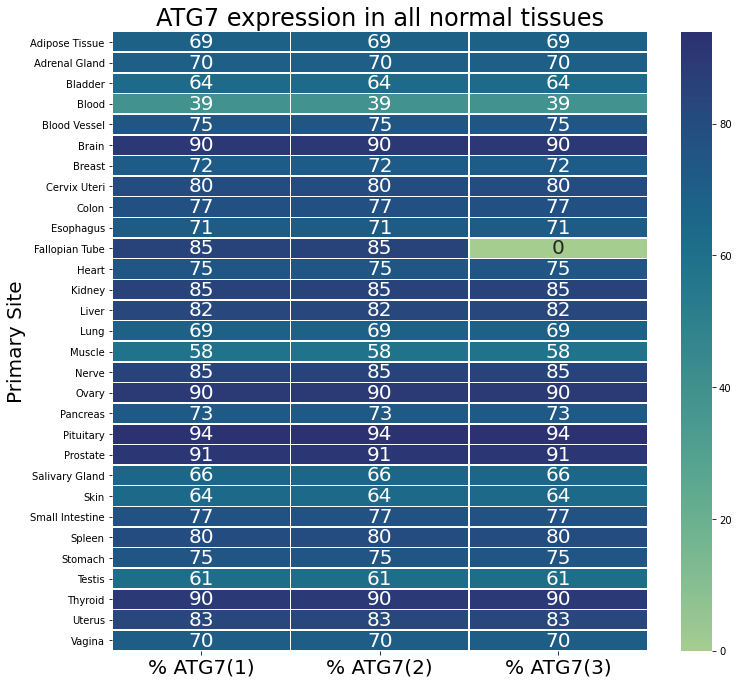

In [22]:
HeatMap_df_sampletype = df_sampletype[['% ATG7(1)', '% ATG7(2)', '% ATG7(3)']]
heatmap = seaborn.heatmap(HeatMap_df_sampletype, annot=True, cmap="crest", linewidths=.5)
plt.title('ATG7 expression in all normal tissues')
plt.subplots_adjust(top=1.2)

path = 'ATG7/figs_ATG7_characterisation/'
plt.savefig(output_file_directory+path+'heatmap_organs.svg')

In [ ]:
# df with only Normal 
hist_df_sampletype = df_sampletype.reset_index()
hist_df_sampletype = hist_df_sampletype[['Primary Site','tpm ATG7']]
hist_df_sampletype.head(1)

In [ ]:
# Seaborn
seaborn.barplot(data = hist_df_sampletype, x =  'tpm ATG7', y = 'Primary Site', color = 'mediumaquamarine')
plt.title('ATG7 expression in all normal tissues')
plt.xlabel('ATG7 expression in TPM')
plt.subplots_adjust(top=1.2)

path = 'ATG7/figs_ATG7_characterisation/'
plt.savefig(output_file_directory+path+'barplot_tpm.svg')

##A) Distribution


In [ ]:
# Distribution graph, for ATG7, iso1 & iso2
all_dfs = [[df_ATG7_Normal, 'in all tissue', df_ATG7_Primary, 'all primary tumors']]

isoforms = [['log2_p1_ATG7_total', 'ATG7'], ['log2_p1_ATG7_1', 'ATG7(1)'], ['log2_p1_ATG7_2', 'ATG7(2)']]


for df in all_dfs:
  for isoform in isoforms:
    xData = df[0][isoform[0]]
    x2Data = df[2][isoform[0]]

    seaborn.kdeplot(xData, color = 'mediumaquamarine', fill = True)
    seaborn.kdeplot(x2Data, color = 'sandybrown', fill = True)

    plt.xlabel('log2 '+ isoform[1]+ ' +1')
    plt.title(isoform[1]+ ' expression ' + df[1] )
    plt.legend(labels=["Normal Tissue","Primary Tumor "])
    title_file = 'distrib_' + isoform[1]
    path = 'ATG7/figs_ATG7_characterisation/'
    plt.savefig(output_file_directory+path+title_file+'.svg')
    plt.show()
    plt.clf()

##B) Percentage do not express ATG7 isoforms

In [ ]:
#Percentage of patients: 
all_dfs = [[df_ATG7_Normal, 'all normal tissue'], [df_ATG7_Primary, 'all primary tumor']]

isoforms = [['ATG7_total', 'ATG7'], ['ATG7_1tpm', 'ATG7(1)'], ['ATG7_2tpm', 'ATG7(2)'], ['ATG7_3tpm', 'ATG7(3)']]

for df in all_dfs:
  print(df[1])
  for isoform in isoforms:
        
    QUOI = isoform[1]
    OU = df[1]
    all = (df[0][isoform[0]]).shape
    no_exp = (df[0][isoform[0]]<0.1).sum()
    perc_no_exp = (no_exp*100)/all
    perc_no_exp = float(perc_no_exp)

    # print("The percentage of patient who do not express", QUOI, OU, "is:", round(perc_no_exp,1),'%')
    print(round(perc_no_exp,1),'% of tumor do not express', QUOI)
  print()


## C) Expression figures

### 1) Value TPM

16614


<ipython-input-23-171bde909bb2>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_distrib['x'][: shape] = 'ATG7'
C:\Users\kja11\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-23-171bde909bb2>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_distrib['x'][shape: shape*2] = 'ATG7(1)'
<ipython-input-23-171bde909bb2>:

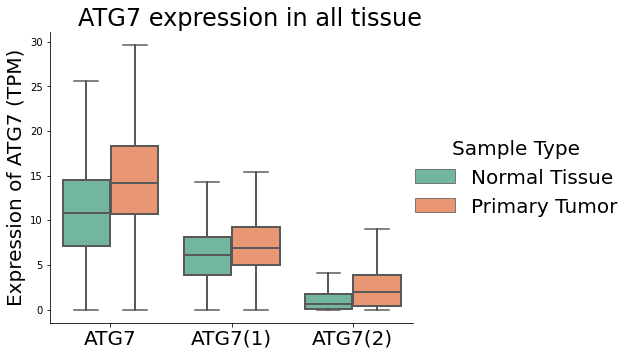

In [23]:
# Distribution: Data preparation + graph
data = [[df_Norm_Prim, 'all tissue']]

for df in data:
   
  shape = df[0].shape
  shape = shape[0]
  print(shape)

  #select the sample type column
  sample_type = {'sample_type':[df[0].iloc[:,1][i]
      for i in range(0, shape)]}

  #convert to df, and copy it 3 times
  sample_typedf = pandas.DataFrame(sample_type)
  sample_typedf = pandas.concat([sample_typedf,sample_typedf,sample_typedf])
  sample_typedf.reset_index(drop=True, inplace=True)

  # Y for expression value 
  y = {'y':[df[0].iloc[:,j][i]
      for j in range(7,10)
        for i in range(0, shape)]}

  #create df with Y 
  data_distrib = pandas.DataFrame(y)

  # X for ATG7/iso1/iso2
  data_distrib['x'] = ''
  data_distrib['x'][: shape] = 'ATG7'
  data_distrib['x'][shape: shape*2] = 'ATG7(1)'
  data_distrib['x'][shape*2:] = 'ATG7(2)'

  # Will be used for Hue
  data_distrib['Sample Type'] = sample_typedf['sample_type']

  #graph
  seaborn.catplot(x="x", y="y", hue="Sample Type", aspect= 1.2, kind="box", palette = 'Set2', data = data_distrib, 
                  boxprops={'lw':2}, medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)
  
  plt.ylabel('Expression of ATG7 (TPM)')
  plt.xlabel('')
  plt.title('ATG7 expression in '+ df[1], x=.55)
  
  #save
  path = 'ATG7/figs_ATG7_characterisation/'
  plt.savefig(output_file_directory+path+'ATG7_exp_alltissue.svg')

In [24]:
#Distribution: Stats for all 

all_dfs = [[df_ATG7_Normal, 'all normal tissue', df_ATG7_Primary, 'all primary tumors']]

isoforms = ['ATG7', 'ATG7(1)', 'ATG7(2)']

for df in all_dfs:
  for isoform in isoforms:

    n1 = "{:.3f}".format(numpy.median(df[0][isoform]))
    n2 = "{:.3f}".format(numpy.median(df[2][isoform]))

    # Mann-Whitney analysis 
    statistic, pvalue = scipy.stats.mannwhitneyu(df[0][isoform], df[2][isoform])
    Pvalue = "{:.3E}".format(pvalue)
    print("the pvalue between", df[1]+'('+n1+')', "and", df[3]+'('+n2+')', "for", isoform, 'is', Pvalue)
  print()


the pvalue between all normal tissue(3.438) and all primary tumors(3.820) for ATG7 is 0.000E+00
the pvalue between all normal tissue(6.129) and all primary tumors(6.858) for ATG7(1) is 6.188E-109
the pvalue between all normal tissue(0.670) and all primary tumors(1.930) for ATG7(2) is 0.000E+00



In [25]:
#median brut file to compare 
print(df_Norm_Prim['ATG7_total'].mean())
print(df_Norm_Prim['ATG7_1tpm'].mean())
print(df_Norm_Prim['ATG7_2tpm'].mean())

13.330134367799564
6.849488322969236
1.8954335752090787


In [26]:
#median after modification to be sure I selected the good ones
data_distribtest = data_distrib[data_distrib['x'] == 'ATG7']
data_distribtest1 = data_distrib[data_distrib['x'] == 'ATG7(1)']
data_distribtest2 = data_distrib[data_distrib['x'] == 'ATG7(2)']
print(data_distribtest.mean())
print(data_distribtest1.mean())
print(data_distribtest2.mean())

y    13.330134
dtype: float64
y    6.849488
dtype: float64
y    1.895434
dtype: float64


### 2) Normalized

16614


<ipython-input-27-faae8e914ae5>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_distrib['x'][: shape] = 'ATG7(1)/ATG7'
C:\Users\kja11\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-27-faae8e914ae5>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_distrib['x'][shape:] = 'ATG7(2)/ATG7'


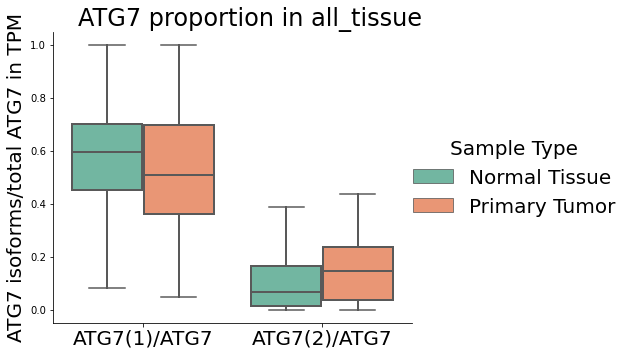

In [27]:
# NORMALiZED Distribution: Data preparation + graph

data = [[df_Norm_Prim, 'all_tissue']]

for df in data:
   
  shape = df[0].shape
  shape = shape[0]
  print(shape)

  #select the sample type column
  sample_type = {'sample_type':[df[0].iloc[:,1][i]
      for i in range(0, shape)]}

  #convert to df, and copy it 3 times
  sample_typedf = pandas.DataFrame(sample_type)
  sample_typedf = pandas.concat([sample_typedf,sample_typedf,sample_typedf])
  sample_typedf.reset_index(drop=True, inplace=True)

  # Y for expression value 
  y = {'y':[df[0].iloc[:,j][i]
      for j in range(18,20)
        for i in range(0, shape)]}

  #create df with Y 
  data_distrib = pandas.DataFrame(y)

  # X for iso1/ATG7 and iso2/ATG7
  data_distrib['x'] = ''
  data_distrib['x'][: shape] = 'ATG7(1)/ATG7'
  data_distrib['x'][shape:] = 'ATG7(2)/ATG7'


  # Will be used for Hue
  data_distrib['Sample Type'] = sample_typedf['sample_type']

  #graph
  seaborn.catplot(x="x", y="y", hue="Sample Type", aspect= 1.2, kind="box", palette = 'Set2', data = data_distrib, 
                  boxprops={'lw':2}, medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)
  
  plt.ylabel('ATG7 isoforms/total ATG7 in TPM')
  plt.xlabel('')
  plt.title('ATG7 proportion in '+ df[1], x=0.55)

  #save graph
  path = 'ATG7/figs_ATG7_characterisation/'
  plt.savefig(output_file_directory+path+'prop_alltissue.svg')



In [28]:
#NORMALIZED Distribution: Stats for all 

all_dfs = [[df_ATG7_Normal, 'all normal tissue', df_ATG7_Primary, 'all primary tumors']]

isoforms = ['ATG7_1norm', 'ATG7_2norm']
print('NORMALIZED')

for df in all_dfs:
  for isoform in isoforms:

    n1 = "{:.3f}".format(numpy.median(df[0][isoform]))
    n2 = "{:.3f}".format(numpy.median(df[2][isoform]))

    # Mann-Whitney analysis 
    statistic, pvalue = scipy.stats.mannwhitneyu(df[0][isoform], df[2][isoform])
    Pvalue = "{:.3E}".format(pvalue)
    print("the pvalue between", df[1]+'('+n1+')', "and", df[3]+'('+n2+')', "for", isoform, 'is', Pvalue)
  print()


NORMALIZED
the pvalue between all normal tissue(0.595) and all primary tumors(0.507) for ATG7(1)norm is 2.372E-53
the pvalue between all normal tissue(0.068) and all primary tumors(0.146) for ATG7(2)norm is 8.074E-187



# IV] Expression correlation 

## 1) between the two isoforms

shape: (9185, 20)
shape after removing extrem dots: (9176, 20)
The correlation between iso1 and iso2 in normal tissue is: 0.02366015296692227 0.0414250994345116


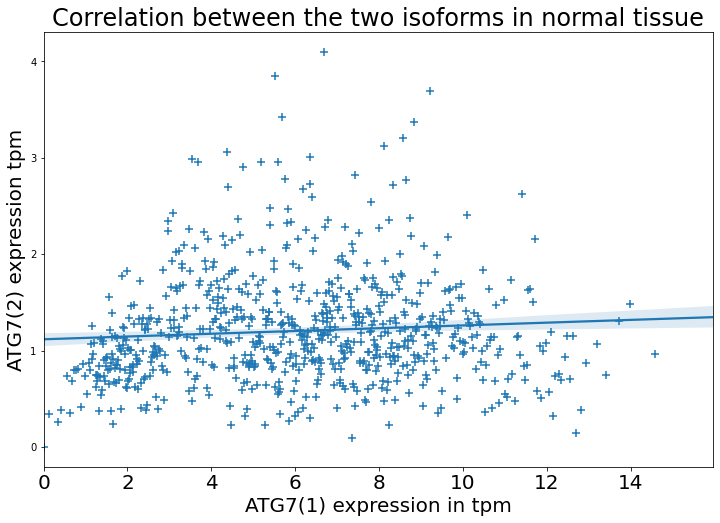


The correlation between iso1 and iso2 in primary tumor is: -0.1894636901702883 6.56308203038513e-75


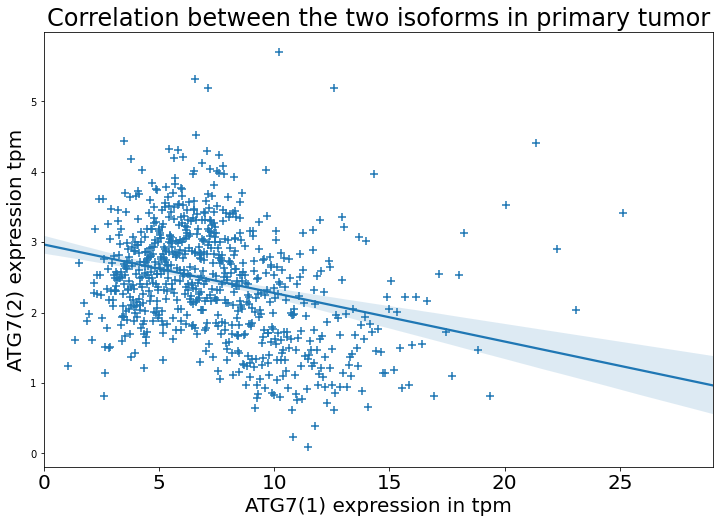

<Figure size 864x576 with 0 Axes>

In [29]:
#isoform correlation in all tissue 
#three values are very high and make my graph ugly... I remove them.
df_ATG7_Primary2 = df_ATG7_Primary[df_ATG7_Primary['ATG7_1'] < 30 ]
print("shape:",df_ATG7_Primary.shape)
print("shape after removing extrem dots:",df_ATG7_Primary2.shape)


tissues = [[df_ATG7_Normal, "normal tissue"], [df_ATG7_Primary2, "primary tumor"]]

for tissue in tissues: 
  x = tissue[0]['ATG7_1tpm'].to_list()
  y = tissue[0]['ATG7_2tpm'].to_list()

  r_value, p_value = scipy.stats.spearmanr(x, y)
  print("The correlation between iso1 and iso2 in",tissue[1],"is:", r_value, p_value)

  seaborn.regplot(x=x,y=y, x_bins=800, x_ci = 0, marker="+")
  name = "Correlation between the two isoforms in "+  tissue[1]
  plt.title(name)
  plt.xlabel("ATG7(1) expression in tpm")
  plt.ylabel('ATG7(2) expression tpm')
  title_file = 'ATG7s_corr_' + tissue[1]
  
  #save
  path = 'ATG7/figs_ATG7_characterisation/'
  plt.savefig(output_file_directory+path+'prop_alltissue.svg')
  
  plt.show()  
  plt.clf()
  print()


##2) between all protein coding

In [30]:
#to know the ensembl code for HK2
protein_coding_list.loc[protein_coding_list['hgnc_symbol'] == 'MFAP3']

,ensembl_gene_id,hgnc_symbol,entrezgene_id,transcript_biotype
19160,ENSG00000037749,MFAP3,4238.0,protein_coding


In [31]:
# Spearman Correlation, main genes 
all_tissue_used = [[ensembl_normal_atg7_proteinGE,'Normal Tissue'], [ensembl_primary_atg7_proteinGE,'Primary Tumors']]

HK2 = 'ENSG00000159399'
YAP1 = 'ENSG00000137693'
AJUBA = 'ENSG00000129474'
YBX1 = 'ENSG00000065978'
TGFB1 = 'ENSG00000105329'
ATG7_1 = 'ATG7_1'
ATG7_2 = 'ATG7_2'
MTDH = 'ENSG00000147649'
MAPK1 = 'ENSG00000100030'
KPNA1 = 'ENSG00000114030'
TNPO1 = 'ENSG00000083312'

for tissue in all_tissue_used:
  genes_x = [[KPNA1,'KPNA1'], [MAPK1, 'MAPK1'], [TNPO1,'TNPO1'], [MTDH,'MTDH'], 
             [HK2, "HK2"], [YAP1, 'YAP1'], [AJUBA,'AJUBA'], [YBX1,'YBX1'], 
             [TGFB1,'TGFB1'], [ATG7_1,'ATG7_1'], [ATG7_2,'ATG7_2']]

  print(tissue[1])

  for gene in genes_x:
    x = tissue[0][gene[0]].to_list()
    y = tissue[0]['ATG7'].to_list()
    y1 = tissue[0]['ATG7_1'].to_list()
    y2 = tissue[0]['ATG7_2'].to_list()  
  
    r_value, p_value = scipy.stats.spearmanr(x, y)
    print('  correlation between ATG7 and', gene[1],  'is:', 'r_value = {:.2f} for a p_value of {:.2e}'.format(r_value, p_value))
    r_value, p_value = scipy.stats.spearmanr(x, y1)
    print('  correlation between ATG7_1 and', gene[1],  'is:', 'r_value = {:.2f} for a p_value of {:.2e}'.format(r_value, p_value))
    r_value, p_value = scipy.stats.spearmanr(x, y2)
    print('  correlation between ATG7_2 and', gene[1],  'is:', 'r_value = {:.2f} for a p_value of {:.2e}'.format(r_value, p_value))
    print()

Normal Tissue
  correlation between ATG7 and KPNA1 is: r_value = 0.52 for a p_value of 0.00e+00
  correlation between ATG7_1 and KPNA1 is: r_value = 0.32 for a p_value of 2.82e-172
  correlation between ATG7_2 and KPNA1 is: r_value = 0.44 for a p_value of 0.00e+00

  correlation between ATG7 and MAPK1 is: r_value = 0.56 for a p_value of 0.00e+00
  correlation between ATG7_1 and MAPK1 is: r_value = 0.35 for a p_value of 3.72e-211
  correlation between ATG7_2 and MAPK1 is: r_value = 0.45 for a p_value of 0.00e+00

  correlation between ATG7 and TNPO1 is: r_value = 0.53 for a p_value of 0.00e+00
  correlation between ATG7_1 and TNPO1 is: r_value = 0.46 for a p_value of 0.00e+00
  correlation between ATG7_2 and TNPO1 is: r_value = 0.25 for a p_value of 2.74e-107

  correlation between ATG7 and MTDH is: r_value = 0.50 for a p_value of 0.00e+00
  correlation between ATG7_1 and MTDH is: r_value = 0.40 for a p_value of 2.52e-277
  correlation between ATG7_2 and MTDH is: r_value = 0.30 for a p_

In [32]:
%%time
# Spearman Correlation, all genes WITHOUT cutoff
all_tissue_used = [[ensembl_normal_atg7_proteinGE,'Normal_Tissues'], [ensembl_primary_atg7_proteinGE,'Primary_Tumors']]

isoforms = ['ATG7_1', 'ATG7_2']

all_positiv_corr_spearman = []
all_negativ_corr_spearman = []

for tissue in all_tissue_used:
  print(tissue[1], tissue[0].shape)

  #create a new row with max() for each gene and transpose
  tissue[0].loc['max()'] = tissue[0].max()
  tissue[0] = tissue[0].T

  #select all row where max() > 2.3 (= 5 tpm)
  nb_before = tissue[0]['max()'].count()
  tissue[0] = tissue[0].drop(tissue[0].index[0:2])
  tissue[0] = tissue[0][tissue[0]['max()'] > 2.3]
  nb_after = tissue[0]['max()'].count()
  print("number of genes removed:", nb_before-nb_after)
  print('the minimum of TPM is', tissue[0]['max()'].min())
  
  #delete the column max() and tranpose back
  tissue[0] =  tissue[0].drop('max()', axis = 1) 
  tissue[0] = tissue[0].T
  print('nombre genes after removing < 4tpm', tissue[0].shape)

  for isoform in isoforms:

    genepos = []
    geneneg = []
    rvaluepos = []
    rvalueneg = []
    pvaluepos = []
    pvalueneg = []

    print(isoform)
    x = tissue[0][isoform].to_list()
    genes = tissue[0].columns[3:]

    for gene in genes:
      y = tissue[0][gene].to_list()
      r_value, p_value = scipy.stats.spearmanr(x, y)

      if r_value > 0:
        genepos.append(gene)
        rvaluepos.append(r_value)
        pvaluepos.append(p_value)
        
      elif r_value < 0:
        geneneg.append(gene)
        rvalueneg.append(r_value)
        pvalueneg.append(p_value)

    #create a dictionnary
    d = dict(ensembl_gene_id= genepos, r_value=rvaluepos,  p_value=pvaluepos)
    d2 = dict(ensembl_gene_id= geneneg, r_value=rvalueneg,  p_value=pvalueneg)

    #Convert to dataframe
    df_positiv_corr = pandas.DataFrame.from_dict(d, orient='index')
    df_negativ_corr = pandas.DataFrame.from_dict(data=d2, orient='index')

    #Transpose to have a better table
    df_positiv_corr = df_positiv_corr.transpose()
    df_negativ_corr = df_negativ_corr.transpose()

    #name
    positiv_corr = 'pos_spearman_corr_'+tissue[1]+'_'+isoform
    negativ_corr = 'neg_spearman_corr_'+tissue[1]+'_'+isoform

    print(positiv_corr, df_positiv_corr.shape)
    print(negativ_corr, df_negativ_corr.shape)

    #scending orde, save to excel
    df_positiv_corr['info'] = tissue[1]+'_'+isoform
    df_positiv_corr = protein_coding_list.merge(df_positiv_corr)
    df_positiv_corr = df_positiv_corr.drop(['entrezgene_id', 'transcript_biotype'], axis = 1)
    df_positiv_corr = df_positiv_corr.sort_values(['r_value'], ascending = False)
    
    #save positive
    path = 'ATG7/table_correlation_enrichr/all_tissue_ATG7/'
    df_positiv_corr.to_excel(output_file_directory+path+positiv_corr+'.xlsx', index=False)
    
    df_negativ_corr['info'] = tissue[1]+'_'+isoform
    df_negativ_corr = protein_coding_list.merge(df_negativ_corr)
    df_negativ_corr = df_negativ_corr.drop(['entrezgene_id', 'transcript_biotype'], axis = 1)
    df_negativ_corr = df_negativ_corr.sort_values(['r_value'], ascending = False)
    
    #save negative
    df_negativ_corr.to_excel(output_file_directory+path+negativ_corr+'.xlsx', index=False)

    all_positiv_corr_spearman.append(df_positiv_corr)
    all_negativ_corr_spearman.append(df_negativ_corr)
  print()

Normal_Tissues (7429, 19387)
number of genes removed: 943
the minimum of TPM is 2.3019
nombre genes after removing < 4tpm (7429, 18443)
ATG7_1
pos_spearman_corr_Normal_Tissues_ATG7_1 (17880, 3)
neg_spearman_corr_Normal_Tissues_ATG7_1 (560, 3)
ATG7_2
pos_spearman_corr_Normal_Tissues_ATG7_2 (10784, 3)
neg_spearman_corr_Normal_Tissues_ATG7_2 (7656, 3)

Primary_Tumors (9185, 19387)
number of genes removed: 841
the minimum of TPM is 2.3048
nombre genes after removing < 4tpm (9185, 18546)
ATG7_1
pos_spearman_corr_Primary_Tumors_ATG7_1 (12861, 3)
neg_spearman_corr_Primary_Tumors_ATG7_1 (5682, 3)
ATG7_2
pos_spearman_corr_Primary_Tumors_ATG7_2 (13937, 3)
neg_spearman_corr_Primary_Tumors_ATG7_2 (4606, 3)

Wall time: 6min 11s


In [33]:
ensembl_normal_atg7_proteinGE.head()

,Sample_Type,Primary_Site,ATG7,ATG7_1,ATG7_2,ENSG00000198888,ENSG00000198763,ENSG00000198804,ENSG00000198712,ENSG00000228253,...,ENSG00000160678,ENSG00000160679,ENSG00000143553,ENSG00000214193,ENSG00000196182,ENSG00000181817,ENSG00000116885,ENSG00000116898,ENSG00000119535,ENSG00000142694
0,Normal Tissue,Muscle,5.042,3.860,2.390,14.0639,13.9595,13.8503,14.4453,15.0971,...,2.7868,5.6494,5.0193,2.6940,4.5274,5.0998,2.3423,6.0790,6.4861,4.9700
1,Normal Tissue,Muscle,4.252,2.322,1.956,13.9265,13.5455,15.2642,14.3855,15.1867,...,9.3501,6.1104,6.0570,1.1770,6.8792,6.4325,2.1013,6.7035,1.1706,1.3167
2,Normal Tissue,Muscle,3.909,2.602,1.345,14.2878,14.1511,14.3722,13.8211,14.8161,...,9.0646,5.9750,5.1173,1.8683,4.6136,5.0090,2.0604,5.7848,1.7489,4.6514
3,Normal Tissue,Muscle,3.854,2.568,1.428,13.8853,14.2716,15.1167,14.0622,15.5897,...,9.2252,5.4941,5.5880,-0.4521,5.6631,6.3797,2.5683,7.3214,1.6140,1.5563
4,Normal Tissue,Muscle,3.822,2.164,1.293,12.9986,13.7570,14.4661,13.4082,14.0564,...,8.9779,6.1502,5.1330,2.0289,6.8202,6.1789,1.8524,6.7685,2.8838,1.8323


Normal Tissue : (7430, 19387)
 37 are removed from head and tail
 without extremities: (7356, 19387)

Normal Tissue
  correlation between ATG7_1 and ATG7 is: r_value = -0.19 for a p_value of 2.36e-74
  correlation between ATG7_2 and ATG7 is: r_value = 1.00 for a p_value of 0.00e+00


findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


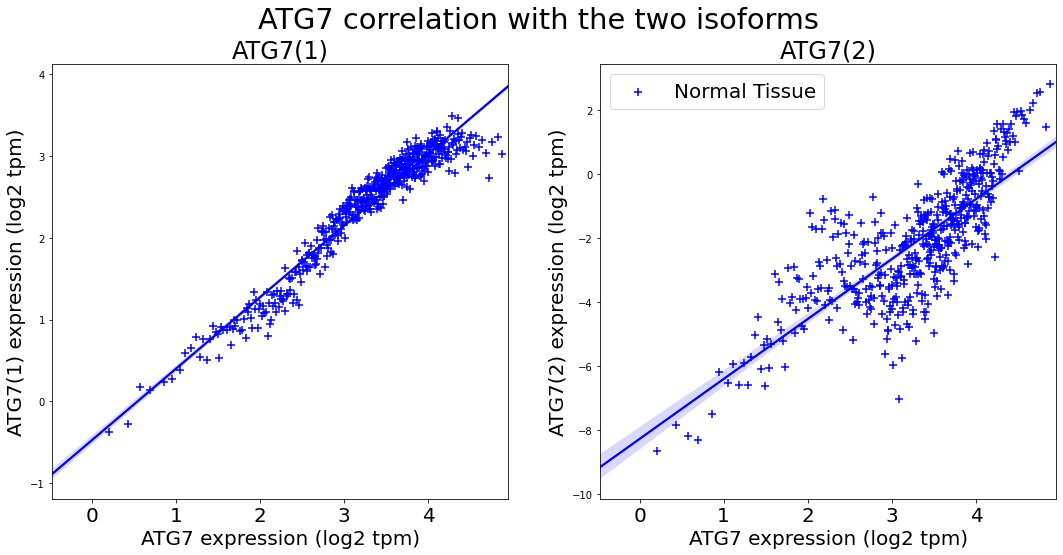

Primary Tumors : (9186, 19387)
 45 are removed from head and tail
 without extremities: (9096, 19387)

Primary Tumors
  correlation between ATG7_1 and ATG7 is: r_value = 0.78 for a p_value of 0.00e+00
  correlation between ATG7_2 and ATG7 is: r_value = 0.49 for a p_value of 0.00e+00


<Figure size 864x576 with 0 Axes>

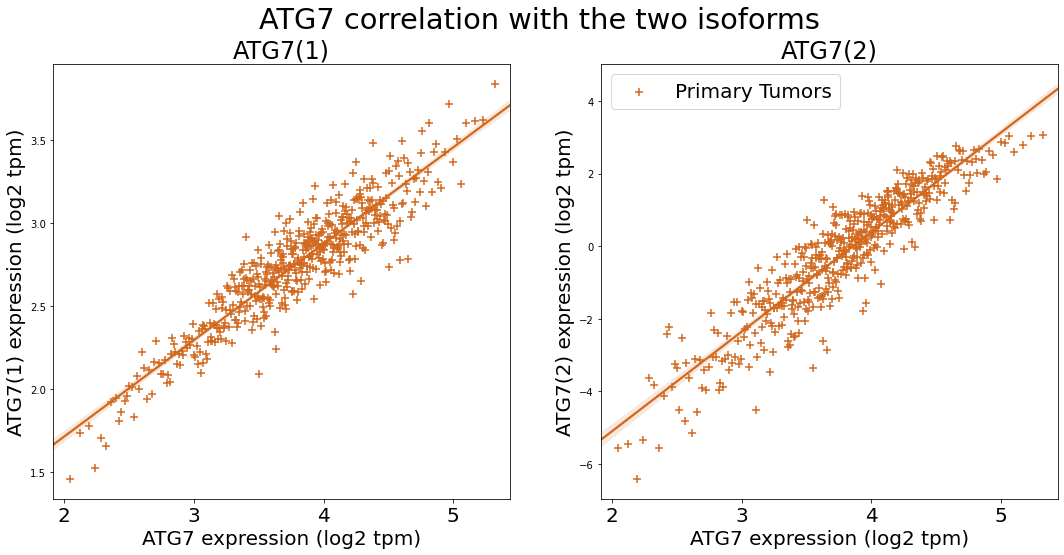


Normal Tissue : (7430, 19387)
 37 are removed from head and tail
 without extremities: (7356, 19387)

Normal Tissue
  correlation between ATG7_1 and ATG7_1 is: r_value = 0.49 for a p_value of 0.00e+00
  correlation between ATG7_2 and ATG7_1 is: r_value = 0.64 for a p_value of 0.00e+00


<Figure size 864x576 with 0 Axes>

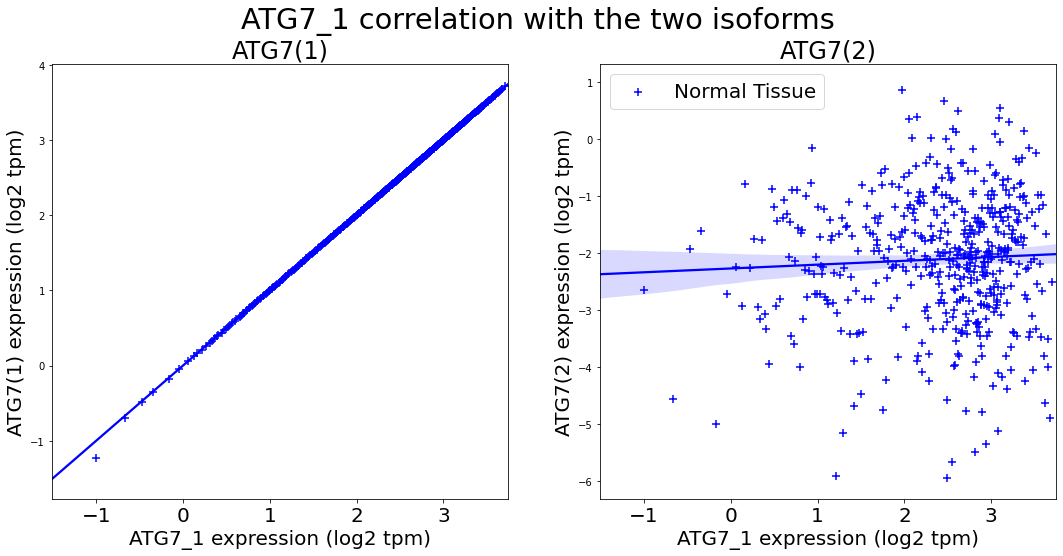

Primary Tumors : (9186, 19387)
 45 are removed from head and tail
 without extremities: (9096, 19387)

Primary Tumors
  correlation between ATG7_1 and ATG7_1 is: r_value = 1.00 for a p_value of 0.00e+00
  correlation between ATG7_2 and ATG7_1 is: r_value = 0.01 for a p_value of 2.08e-01


<Figure size 864x576 with 0 Axes>

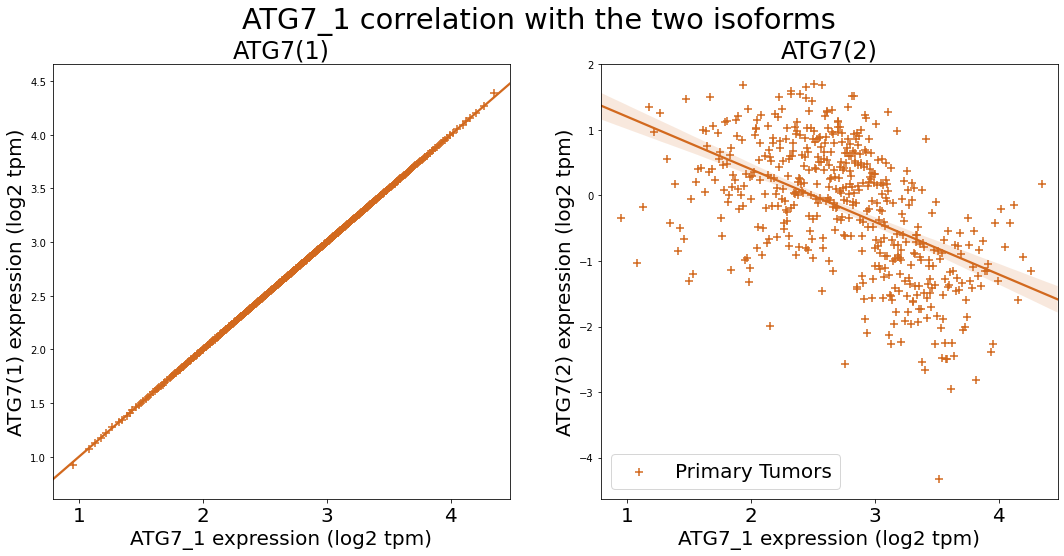


Normal Tissue : (7430, 19387)
 37 are removed from head and tail
 without extremities: (7356, 19387)

Normal Tissue
  correlation between ATG7_1 and MAPK1 is: r_value = 1.00 for a p_value of 0.00e+00
  correlation between ATG7_2 and MAPK1 is: r_value = -0.19 for a p_value of 4.20e-76


<Figure size 864x576 with 0 Axes>

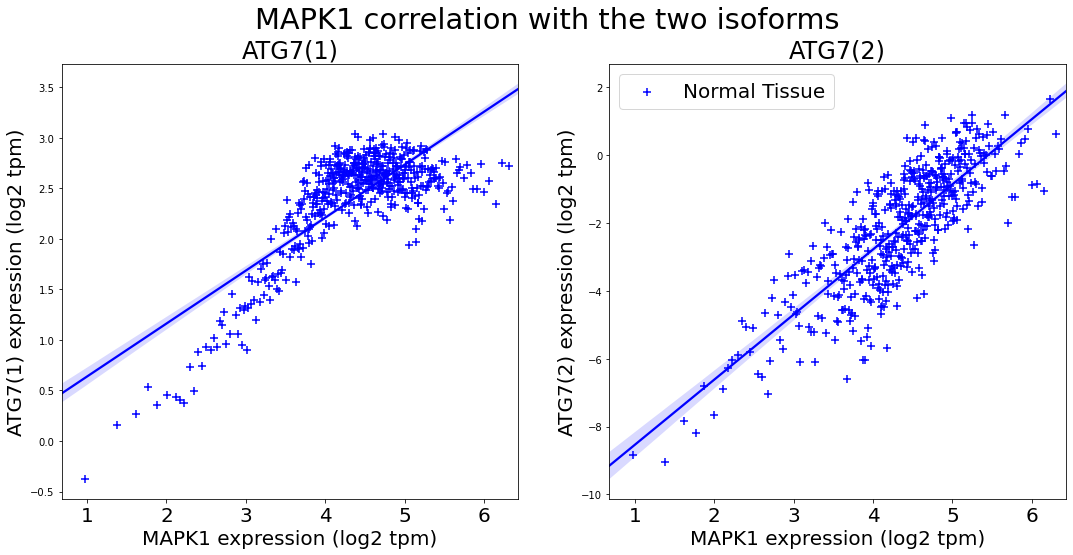

Primary Tumors : (9186, 19387)
 45 are removed from head and tail
 without extremities: (9096, 19387)

Primary Tumors
  correlation between ATG7_1 and MAPK1 is: r_value = 0.34 for a p_value of 2.94e-197
  correlation between ATG7_2 and MAPK1 is: r_value = 0.44 for a p_value of 0.00e+00


<Figure size 864x576 with 0 Axes>

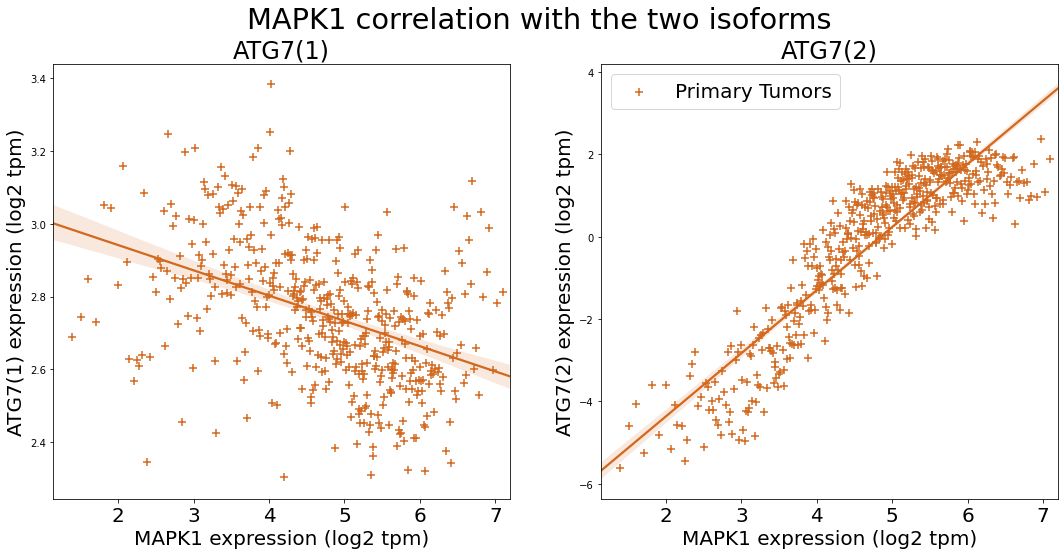


Normal Tissue : (7430, 19387)
 37 are removed from head and tail
 without extremities: (7356, 19387)

Normal Tissue
  correlation between ATG7_1 and MTDH is: r_value = -0.14 for a p_value of 2.76e-39
  correlation between ATG7_2 and MTDH is: r_value = 0.63 for a p_value of 0.00e+00


<Figure size 864x576 with 0 Axes>

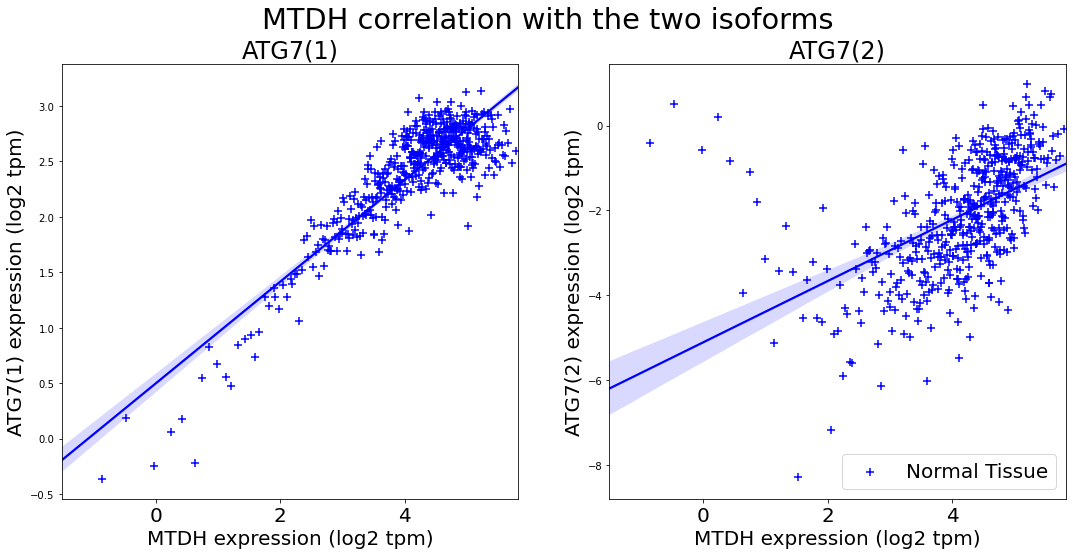

Primary Tumors : (9186, 19387)
 45 are removed from head and tail
 without extremities: (9096, 19387)

Primary Tumors
  correlation between ATG7_1 and MTDH is: r_value = 0.39 for a p_value of 1.36e-263
  correlation between ATG7_2 and MTDH is: r_value = 0.29 for a p_value of 4.77e-140


<Figure size 864x576 with 0 Axes>

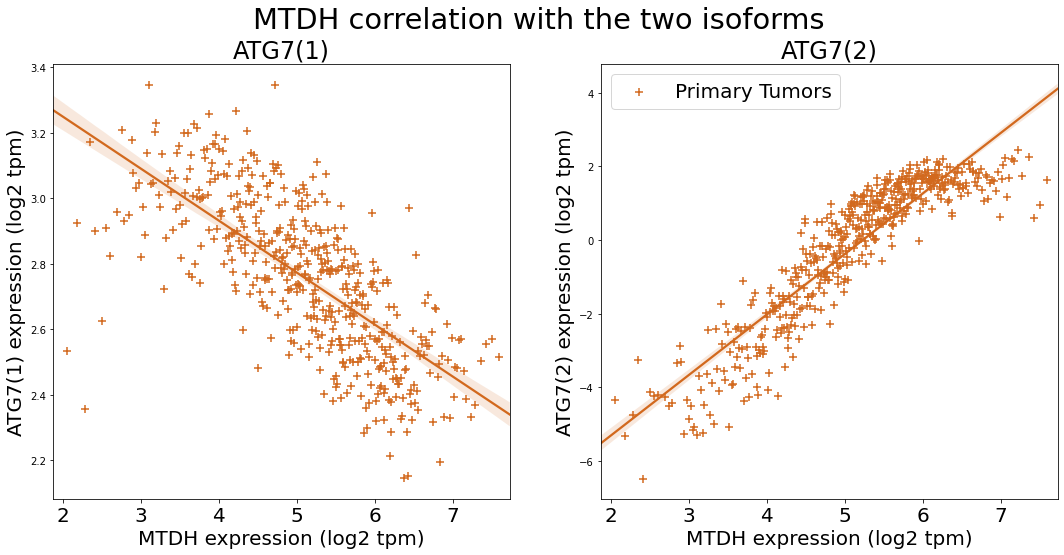


Normal Tissue : (7430, 19387)
 37 are removed from head and tail
 without extremities: (7356, 19387)

Normal Tissue
  correlation between ATG7_1 and KPNA1 is: r_value = -0.28 for a p_value of 2.15e-164
  correlation between ATG7_2 and KPNA1 is: r_value = 0.63 for a p_value of 0.00e+00


<Figure size 864x576 with 0 Axes>

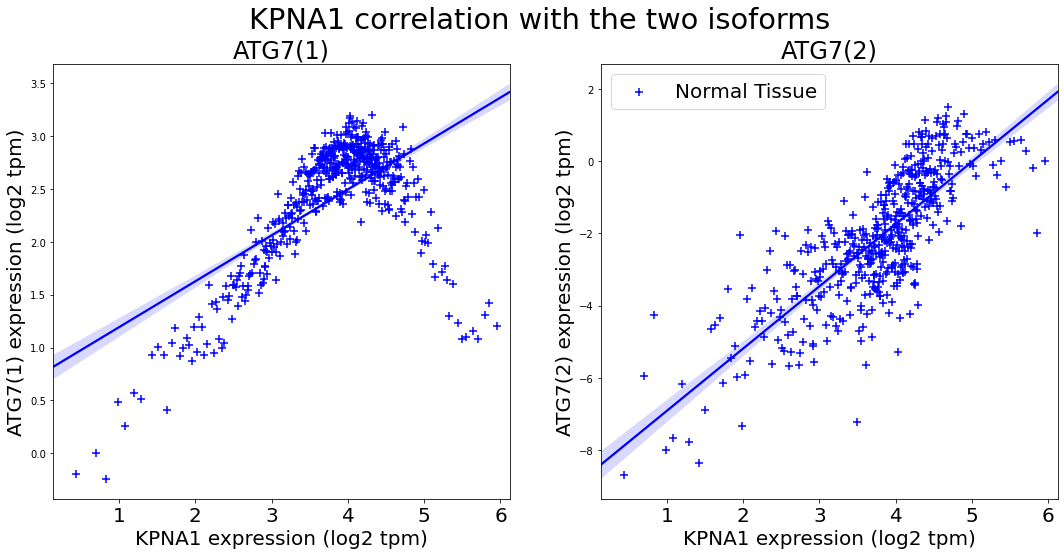

Primary Tumors : (9186, 19387)
 45 are removed from head and tail
 without extremities: (9096, 19387)

Primary Tumors
  correlation between ATG7_1 and KPNA1 is: r_value = 0.32 for a p_value of 1.16e-174
  correlation between ATG7_2 and KPNA1 is: r_value = 0.44 for a p_value of 0.00e+00


<Figure size 864x576 with 0 Axes>

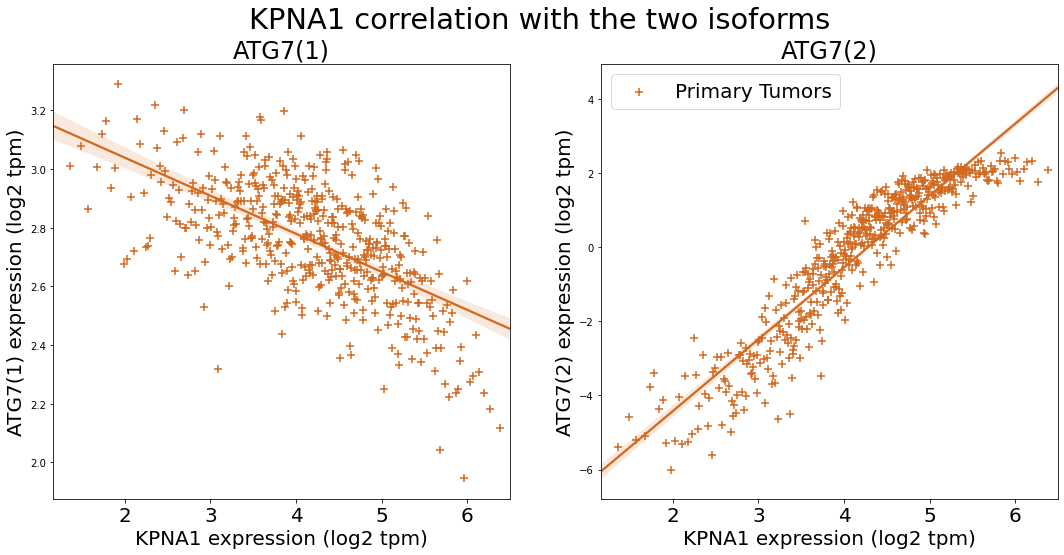


Normal Tissue : (7430, 19387)
 37 are removed from head and tail
 without extremities: (7356, 19387)

Normal Tissue
  correlation between ATG7_1 and TNPO1 is: r_value = -0.18 for a p_value of 1.75e-70
  correlation between ATG7_2 and TNPO1 is: r_value = 0.67 for a p_value of 0.00e+00


<Figure size 864x576 with 0 Axes>

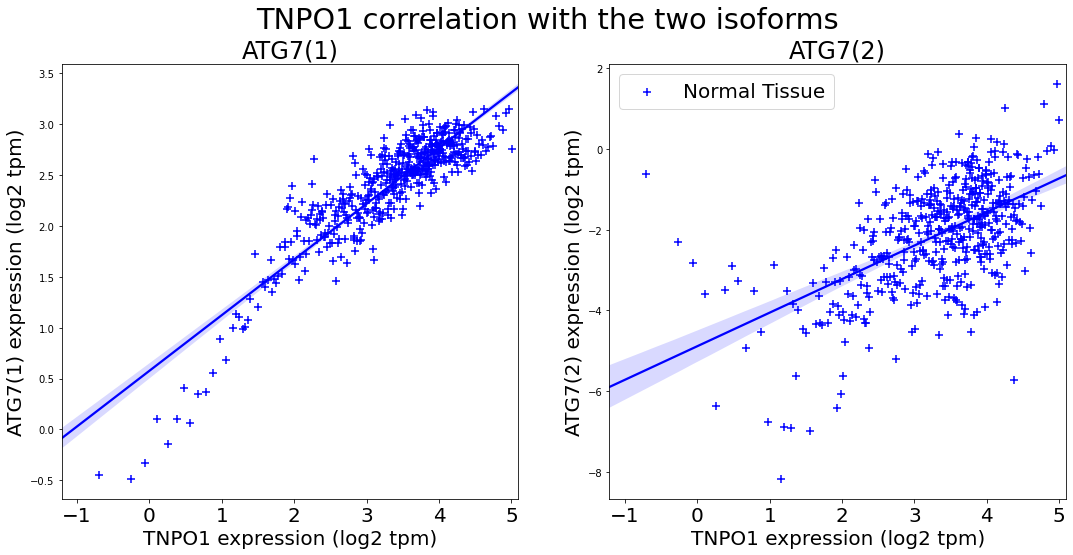

Primary Tumors : (9186, 19387)
 45 are removed from head and tail
 without extremities: (9096, 19387)

Primary Tumors
  correlation between ATG7_1 and TNPO1 is: r_value = 0.45 for a p_value of 0.00e+00
  correlation between ATG7_2 and TNPO1 is: r_value = 0.24 for a p_value of 7.54e-93


<Figure size 864x576 with 0 Axes>

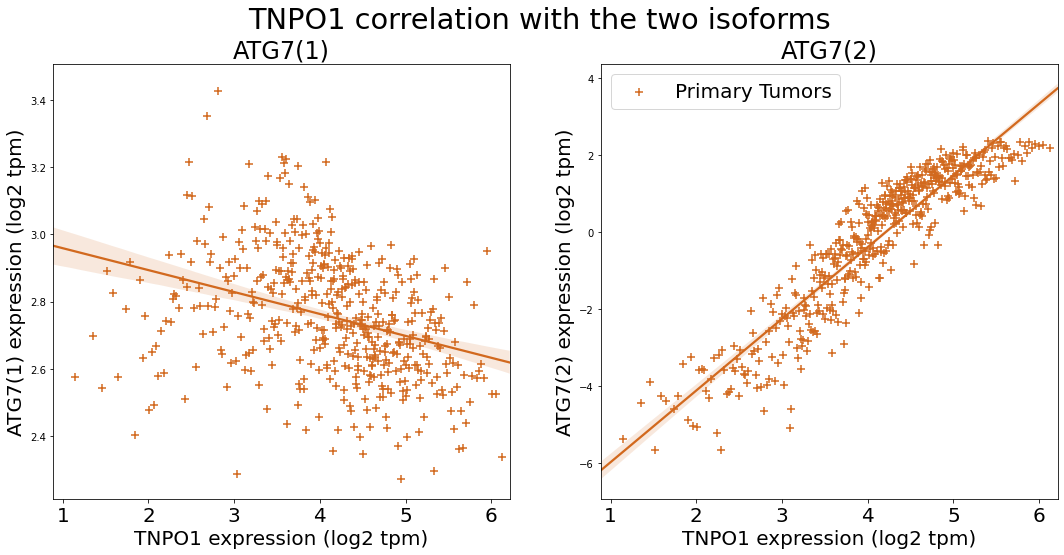


Normal Tissue : (7430, 19387)
 37 are removed from head and tail
 without extremities: (7356, 19387)

Normal Tissue
  correlation between ATG7_1 and HK2 is: r_value = -0.11 for a p_value of 2.04e-27
  correlation between ATG7_2 and HK2 is: r_value = 0.63 for a p_value of 0.00e+00


<Figure size 864x576 with 0 Axes>

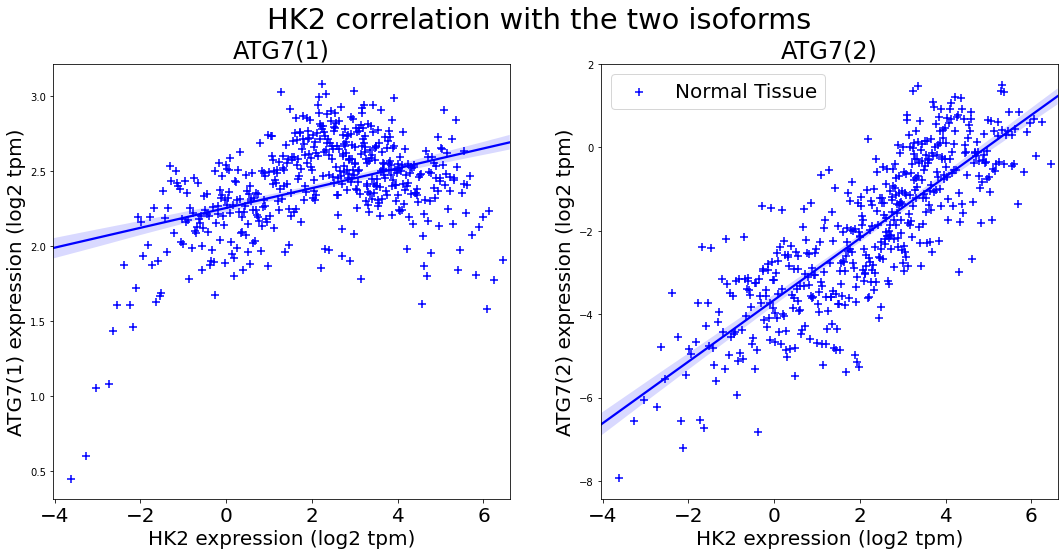

Primary Tumors : (9186, 19387)
 45 are removed from head and tail
 without extremities: (9096, 19387)

Primary Tumors
  correlation between ATG7_1 and HK2 is: r_value = 0.13 for a p_value of 1.51e-30
  correlation between ATG7_2 and HK2 is: r_value = 0.46 for a p_value of 0.00e+00


<Figure size 864x576 with 0 Axes>

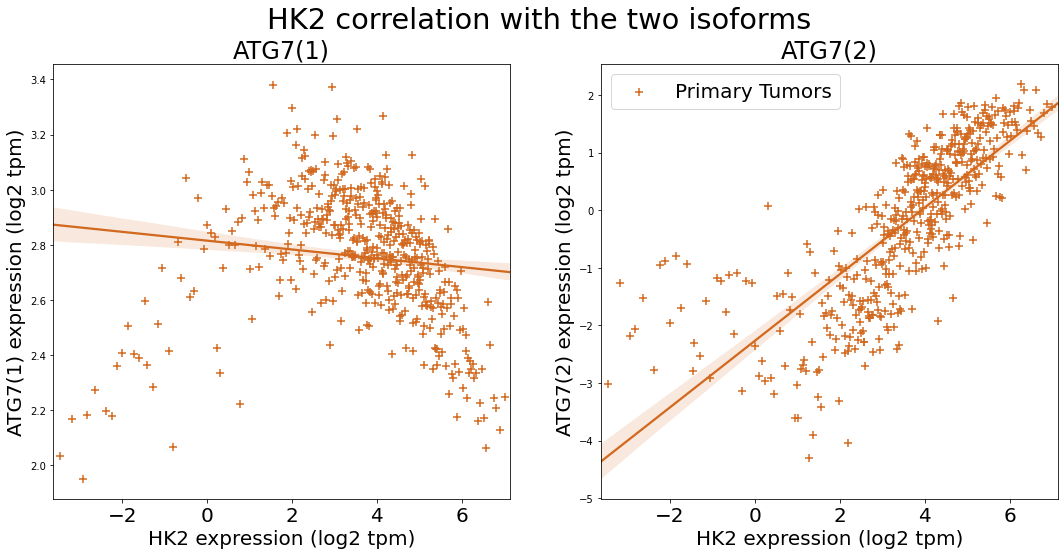


Normal Tissue : (7430, 19387)
 37 are removed from head and tail
 without extremities: (7356, 19387)

Normal Tissue
  correlation between ATG7_1 and YAP1 is: r_value = -0.13 for a p_value of 1.38e-33
  correlation between ATG7_2 and YAP1 is: r_value = 0.42 for a p_value of 0.00e+00


<Figure size 864x576 with 0 Axes>

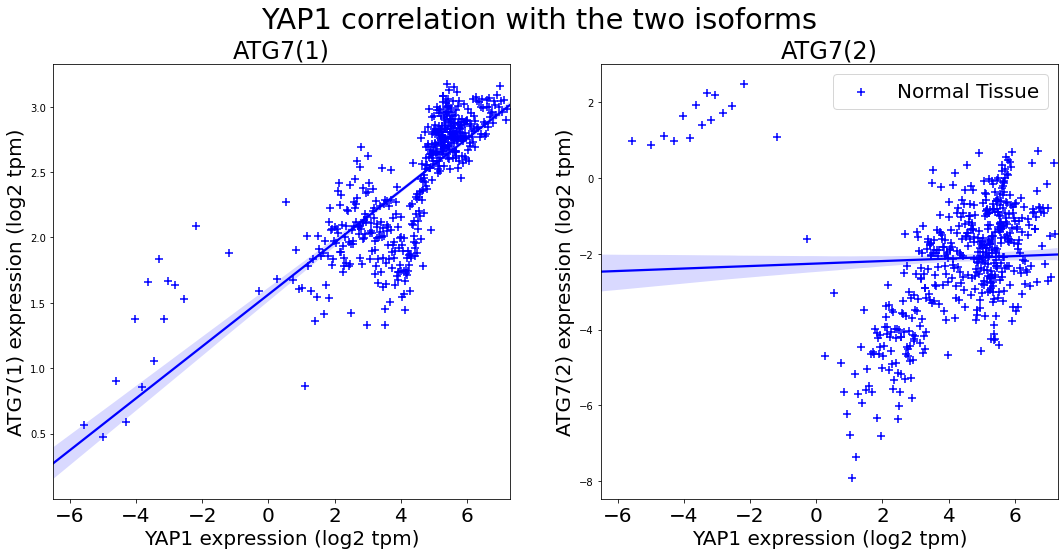

Primary Tumors : (9186, 19387)
 45 are removed from head and tail
 without extremities: (9096, 19387)

Primary Tumors
  correlation between ATG7_1 and YAP1 is: r_value = 0.47 for a p_value of 0.00e+00
  correlation between ATG7_2 and YAP1 is: r_value = 0.20 for a p_value of 1.87e-65


<Figure size 864x576 with 0 Axes>

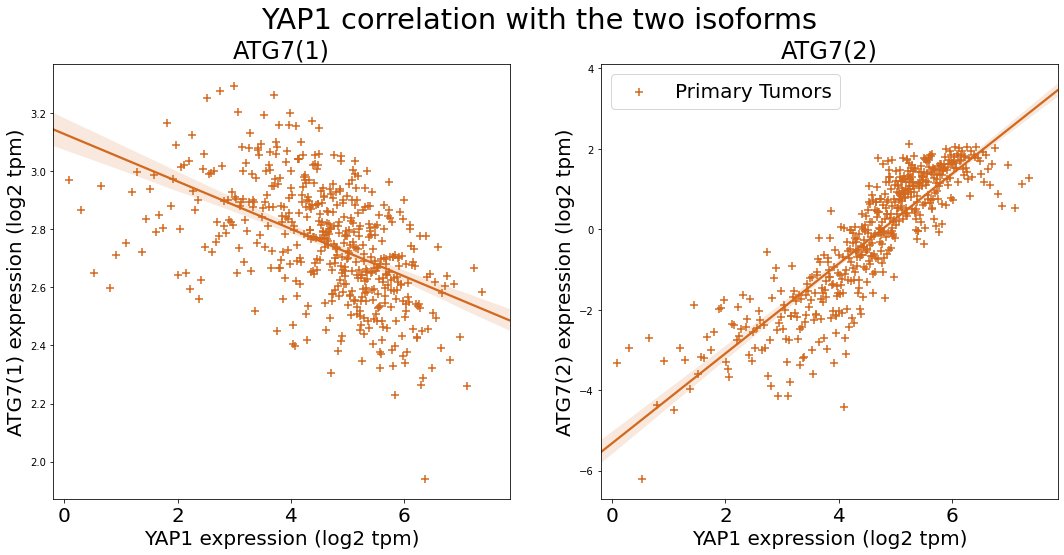


Normal Tissue : (7430, 19387)
 37 are removed from head and tail
 without extremities: (7356, 19387)

Normal Tissue
  correlation between ATG7_1 and AJUBA is: r_value = -0.18 for a p_value of 8.79e-67
  correlation between ATG7_2 and AJUBA is: r_value = 0.50 for a p_value of 0.00e+00


<Figure size 864x576 with 0 Axes>

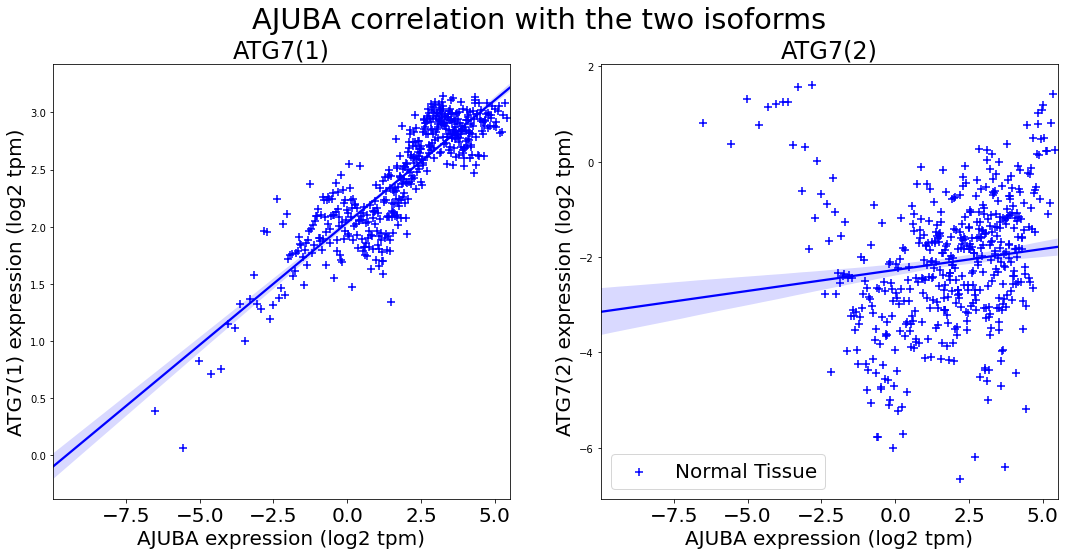

Primary Tumors : (9186, 19387)
 45 are removed from head and tail
 without extremities: (9096, 19387)

Primary Tumors
  correlation between ATG7_1 and AJUBA is: r_value = 0.52 for a p_value of 0.00e+00
  correlation between ATG7_2 and AJUBA is: r_value = 0.15 for a p_value of 3.89e-39


<Figure size 864x576 with 0 Axes>

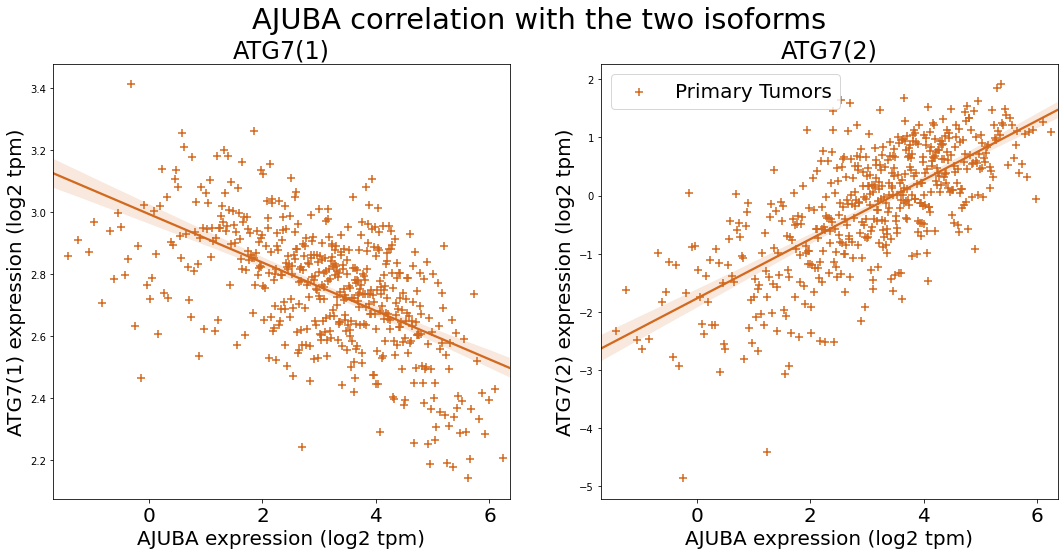


Normal Tissue : (7430, 19387)
 37 are removed from head and tail
 without extremities: (7356, 19387)

Normal Tissue
  correlation between ATG7_1 and YBX1 is: r_value = -0.18 for a p_value of 4.63e-68
  correlation between ATG7_2 and YBX1 is: r_value = 0.25 for a p_value of 5.79e-126


<Figure size 864x576 with 0 Axes>

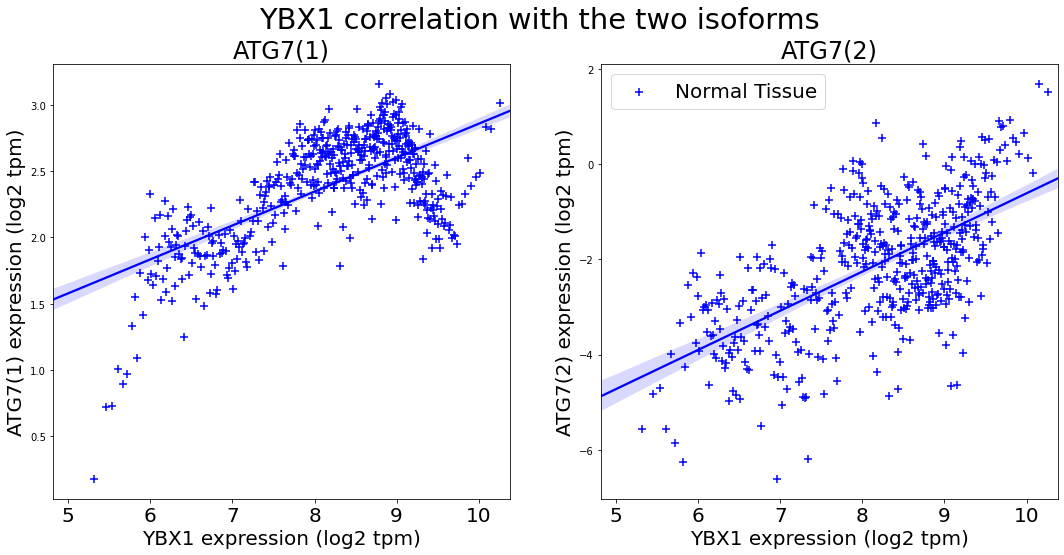

Primary Tumors : (9186, 19387)
 45 are removed from head and tail
 without extremities: (9096, 19387)

Primary Tumors
  correlation between ATG7_1 and YBX1 is: r_value = 0.25 for a p_value of 7.67e-103
  correlation between ATG7_2 and YBX1 is: r_value = 0.24 for a p_value of 1.15e-96


<Figure size 864x576 with 0 Axes>

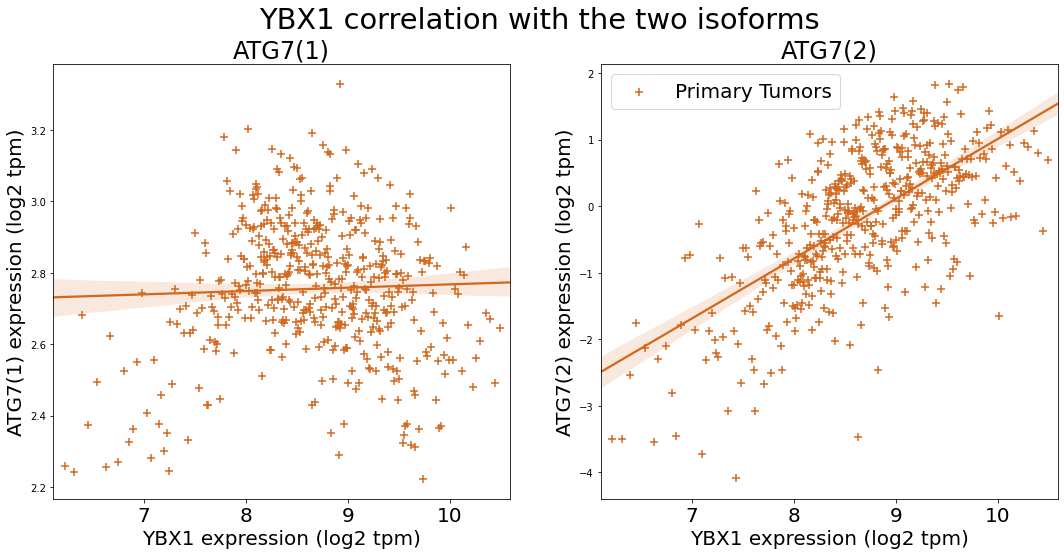


Normal Tissue : (7430, 19387)
 37 are removed from head and tail
 without extremities: (7356, 19387)

Normal Tissue
  correlation between ATG7_1 and TGFB1 is: r_value = -0.03 for a p_value of 9.17e-03
  correlation between ATG7_2 and TGFB1 is: r_value = 0.23 for a p_value of 6.25e-105


<Figure size 864x576 with 0 Axes>

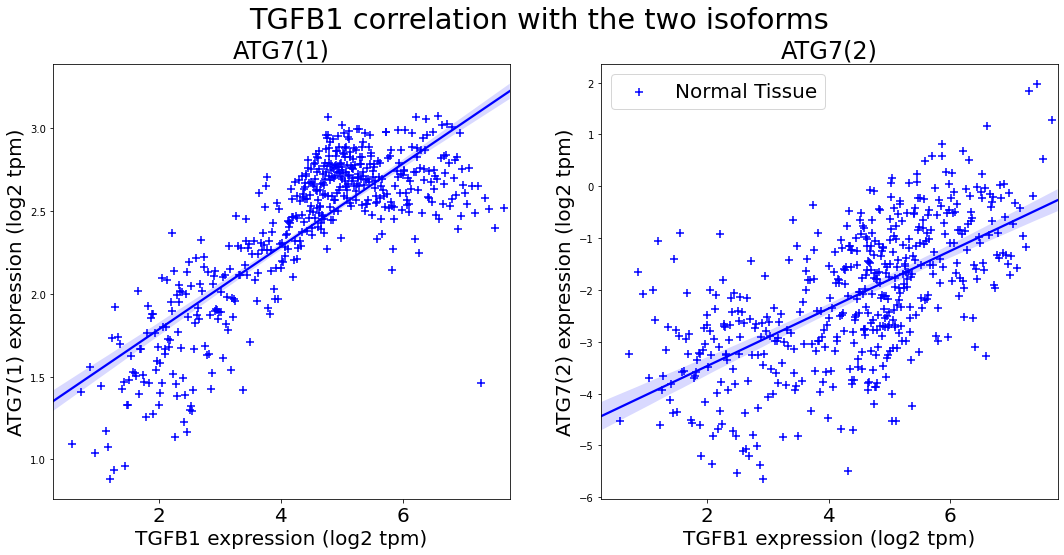

Primary Tumors : (9186, 19387)
 45 are removed from head and tail
 without extremities: (9096, 19387)

Primary Tumors
  correlation between ATG7_1 and TGFB1 is: r_value = 0.41 for a p_value of 2.45e-297
  correlation between ATG7_2 and TGFB1 is: r_value = 0.29 for a p_value of 2.31e-139


<Figure size 864x576 with 0 Axes>

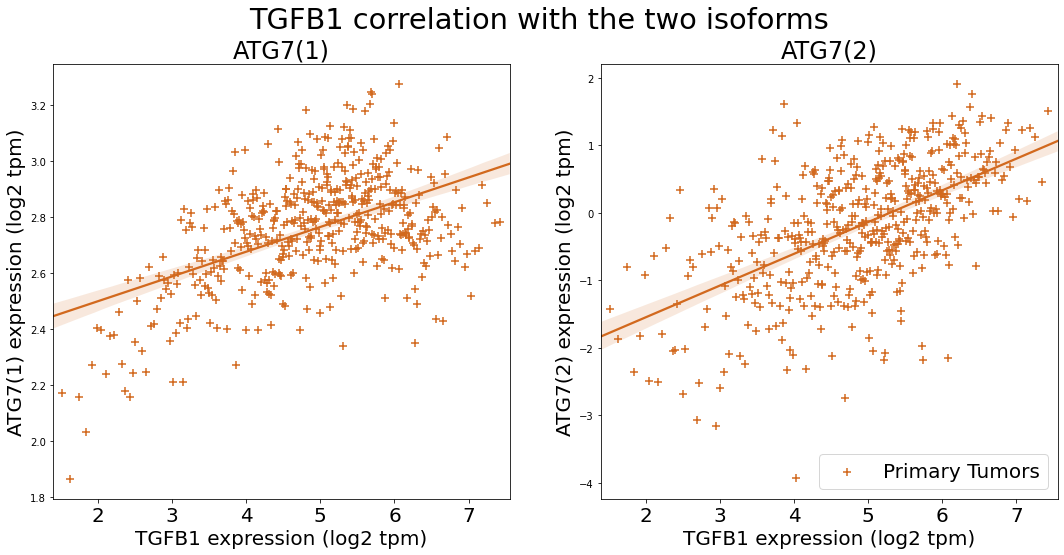


Wall time: 8min 58s


<Figure size 864x576 with 0 Axes>

In [52]:
%%time
#Graphic representation, two graphs in one, remove the extremities to have better graph

all_tissue_used = [[ensembl_normal_atg7_proteinGE,'Normal Tissue', 'blue'], 
                   [ensembl_primary_atg7_proteinGE,'Primary Tumors', 'chocolate']]

HK2 = 'ENSG00000159399'
YAP1 = 'ENSG00000137693'
AJUBA = 'ENSG00000129474'
YBX1 = 'ENSG00000065978'
TGFB1 = 'ENSG00000105329'
MAPK1 = 'ENSG00000100030'
MTDH = 'ENSG00000147649'
KPNA1 = 'ENSG00000114030'
TNPO1 = 'ENSG00000083312'
ATG7 = 'ATG7'
ATG7_1 = 'ATG7_1'
 
genes = [[ATG7,'ATG7'], [ATG7_1,'ATG7_1'], [MAPK1,'MAPK1'], [MTDH,'MTDH'], [KPNA1,'KPNA1'], 
         [TNPO1,'TNPO1'], [HK2,'HK2'], [YAP1,'YAP1'], [AJUBA,'AJUBA'], [YBX1,'YBX1'], [TGFB1,'TGFB1']]

for gene in genes:
    for df in all_tissue_used:
        #sort by value, remove the extremities
        print(df[1], ':', df[0].shape)
        for_genes = df[0].sort_values([gene[0]], ascending = False) 
        lenght = len(for_genes)
        without_05perc = int(lenght*0.005)
        print('', without_05perc, 'are removed from head and tail')
        without_head = without_05perc
        without_tail = lenght - without_05perc
                
        df_no_extrem = for_genes.iloc[without_head:without_tail,:]
        print(' without extremities:', df_no_extrem.shape)
        print()
        
        print(df[1])
        r_value, p_value = scipy.stats.spearmanr(x, y1)
        print('  correlation between ATG7_1 and', gene[1],  'is:', 'r_value = {:.2f} for a p_value of {:.2e}'.format(r_value, p_value))
        r_value, p_value = scipy.stats.spearmanr(x, y2)
        print('  correlation between ATG7_2 and', gene[1],  'is:', 'r_value = {:.2f} for a p_value of {:.2e}'.format(r_value, p_value))
        
        #graph
        fig, ax = plt.subplots(1,2, figsize=(18,8))
        name = gene[1]+ " correlation with the two isoforms"
        name2 = gene[1]+ " expression (log2 tpm)"

        fig.suptitle(name, fontsize="x-large")
 
        x = df_no_extrem[gene[0]].to_list()
        y1 = df_no_extrem['ATG7_1'].to_list()
        y2 = df_no_extrem['ATG7_2'].to_list()

        fig = seaborn.regplot(x=x,y=y1, ax=ax[0], x_bins=500, x_ci = 0, marker="+", label = df[1], color = df[2])
        fig.set_title("ATG7(1)")
        fig.set_xlabel(name2)
        fig.set_ylabel('ATG7(1) expression (log2 tpm)')

        fig = seaborn.regplot(x=x,y=y2, ax=ax[1], x_bins=500, x_ci = 0, marker="+", label = df[1], color = df[2])
        fig.set_title("ATG7(2)")
        fig.set_xlabel(name2)
        fig.set_ylabel('ATG7(2) expression (log2 tpm)')
        plt.legend()
        plt.show()
        plt.clf()
    print()

# V] Distribution of all rvalue to select cutoff

Normal Tissue, ATG7(1)
shape positiv (562, 5)
shape negativ (18009, 5)
shape after merge (18571, 5)

Normal Tissue, ATG7(2)
shape positiv (7720, 5)
shape negativ (10851, 5)
shape after merge (18571, 5)

Primary Tumor, ATG7(1)
shape positiv (5724, 5)
shape negativ (12950, 5)
shape after merge (18674, 5)

Primary Tumor, ATG7(2)
shape positiv (4639, 5)
shape negativ (14035, 5)
shape after merge (18674, 5)

shape normal (18571, 5)
shape primary (18571, 5)
shape after merge (37142, 5)

shape normal (18674, 5)
shape primary (18674, 5)
shape after merge (37348, 5)



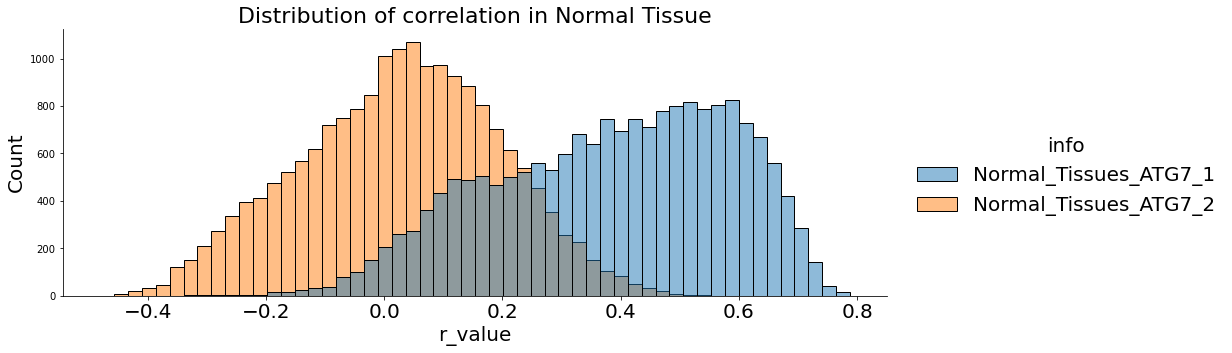

<Figure size 864x576 with 0 Axes>

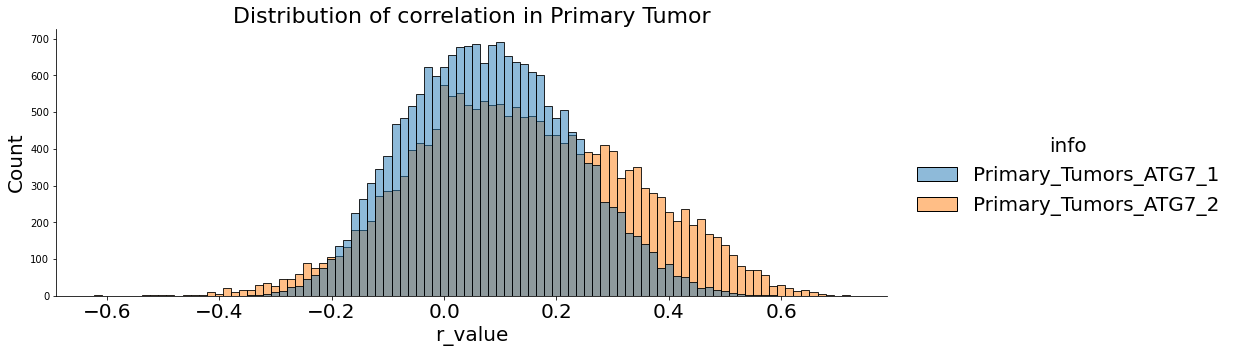


Wall time: 1.77 s


<Figure size 864x576 with 0 Axes>

In [53]:
%%time
#Merge Negative and Positive data
data =  [
         [all_negativ_corr_spearman[0], all_positiv_corr_spearman[0], 'Normal Tissue, ATG7(1)'], 
         [all_negativ_corr_spearman[1], all_positiv_corr_spearman[1], 'Normal Tissue, ATG7(2)'],
         [all_negativ_corr_spearman[2], all_positiv_corr_spearman[2], 'Primary Tumor, ATG7(1)'], 
         [all_negativ_corr_spearman[3], all_positiv_corr_spearman[3], 'Primary Tumor, ATG7(2)']
         ]

all_corr_negpos_merged = []
for dfs in data:
  print(dfs[2])
  print('shape positiv', dfs[0].shape)
  print('shape negativ', dfs[1].shape)

  df_merged = pandas.concat([dfs[0], dfs[1]], axis=0)
  df_merged = df_merged.reset_index(drop = True)
  print('shape after merge', df_merged.shape)
  all_corr_negpos_merged.append(df_merged)
  print()

#Merge ATG7(1) and ATG7(2)
data = [
        [all_corr_negpos_merged[0], all_corr_negpos_merged[1], 'Normal Tissue'],
        [all_corr_negpos_merged[2], all_corr_negpos_merged[3], 'Primary Tumor']
        ]

all_corr_isoforms_merged = []
for dfs in data:
  print('shape normal', dfs[0].shape)
  print('shape primary', dfs[1].shape)

  df_merged = pandas.concat([dfs[0], dfs[1]], axis=0)
  df_merged = df_merged.reset_index(drop = True)
  print('shape after merge', df_merged.shape)
  all_corr_isoforms_merged.append(df_merged)
  print()

#Distribution of correlation
data = [
        [all_corr_isoforms_merged[0], 'Normal Tissue'],
        [all_corr_isoforms_merged[1], 'Primary Tumor']
        ]

for dfs in data:
  seaborn.displot(dfs[0], x="r_value", hue='info', aspect = 2.6)
  label_title = 'Distribution of correlation in ' + dfs[1]
  plt.title(label_title, fontsize = 22)
  plt.show()
  plt.clf()
  print()

In [54]:
# have to select the 1% in extremities to have only the interesting one.
print((len(all_corr_negpos_merged)), '= norm iso1, norm iso2, prim iso1, prim iso2')

4 = norm iso1, norm iso2, prim iso1, prim iso2


In [55]:
all_corr_negpos_extremities = []

for df in all_corr_negpos_merged:
  df = df.sort_values(['r_value'], ascending = False)
  df = df.reset_index(drop = True)
  
  lenght = len(df)
  only_1perc = int(lenght*0.01)
  just_head = only_1perc
  just_tail = lenght - only_1perc

  df_head = df.iloc[0:just_head,:]
  df_tail = df.iloc[just_tail:,:]
  df_extremeties = pandas.concat([df_head, df_tail], axis=0)

  inform = df['info'][1]
  extremities_name = 'corr_1%extremities'+ '_' +inform
  df_extremeties.to_excel(extremities_name+'.xlsx', index=False)

  all_corr_negpos_extremities.append(df_extremeties)

In [56]:
len(all_positiv_corr_spearman)

4

In [57]:
#To know if MAPK2 / TNPO1 / KNPA1 are positively or negativly correlated

interest_genes = ["MAPK1", "TNPO1", "KPNA1"]
for gene in interest_genes:
    print('------------------------------------------------')
    print(gene)
   
#to know the rank 
    for df in all_positiv_corr_spearman:
        print(df['info'][1])
        df.reset_index(drop = True, inplace = True)
        a = df.loc[df['hgnc_symbol'] == gene]
        print(a.iloc[:,1:3])
        print()
        print('-----------------------------------------------')

------------------------------------------------
MAPK1
Normal_Tissues_ATG7_1
      hgnc_symbol  r_value
11017       MAPK1  0.34852

-----------------------------------------------
Normal_Tissues_ATG7_2
   hgnc_symbol   r_value
47       MAPK1  0.445644

-----------------------------------------------
Primary_Tumors_ATG7_1
Empty DataFrame
Columns: [hgnc_symbol, r_value]
Index: []

-----------------------------------------------
Primary_Tumors_ATG7_2
   hgnc_symbol   r_value
38       MAPK1  0.628597

-----------------------------------------------
------------------------------------------------
TNPO1
Normal_Tissues_ATG7_1
     hgnc_symbol   r_value
7676       TNPO1  0.459086

-----------------------------------------------
Normal_Tissues_ATG7_2
     hgnc_symbol  r_value
1665       TNPO1  0.25121

-----------------------------------------------
Primary_Tumors_ATG7_1
Empty DataFrame
Columns: [hgnc_symbol, r_value]
Index: []

-----------------------------------------------
Primary_Tumors_AT

# VI] Venn diagrams

In [58]:
len(all_corr_negpos_merged)

4

In [59]:
all_corr_negpos_extremities[0]

,ensembl_gene_id,hgnc_symbol,r_value,p_value,info
0,ENSG00000121775,TMEM39B,0.787757,0,Normal_Tissues_ATG7_1
1,ENSG00000230124,ACBD6,0.786925,0,Normal_Tissues_ATG7_1
2,ENSG00000230124,ACBD6,0.786925,0,Normal_Tissues_ATG7_1
3,ENSG00000197548,ATG7,0.785379,0,Normal_Tissues_ATG7_1
4,ENSG00000266173,STRADA,0.784712,0,Normal_Tissues_ATG7_1
...,...,...,...,...,...
18566,ENSG00000198712,MT-CO2,-0.310618,6.96362e-166,Normal_Tissues_ATG7_1
18567,ENSG00000198727,MT-CYB,-0.324487,1.05757e-181,Normal_Tissues_ATG7_1
18568,ENSG00000228253,MT-ATP8,-0.329243,2.52859e-187,Normal_Tissues_ATG7_1
18569,ENSG00000198899,MT-ATP6,-0.329694,7.33804e-188,Normal_Tissues_ATG7_1


In [60]:
#separate pos and neg correlation
all_corr_positiv_extremities = []
all_corr_negativ_extremities = []

for df in all_corr_negpos_extremities:
    data_pos = df[df['r_value']>0]
    data_neg = df[df['r_value']<0]
    all_corr_positiv_extremities.append(data_pos)
    all_corr_negativ_extremities.append(data_neg)
print(len(all_corr_positiv_extremities))

4


In [61]:
print(len(all_corr_negativ_extremities[1]))

185


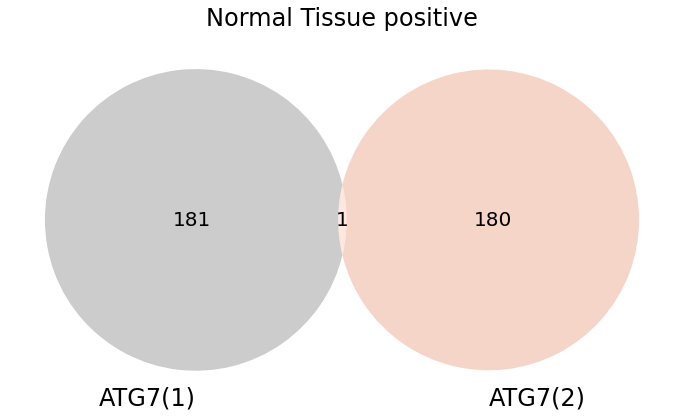

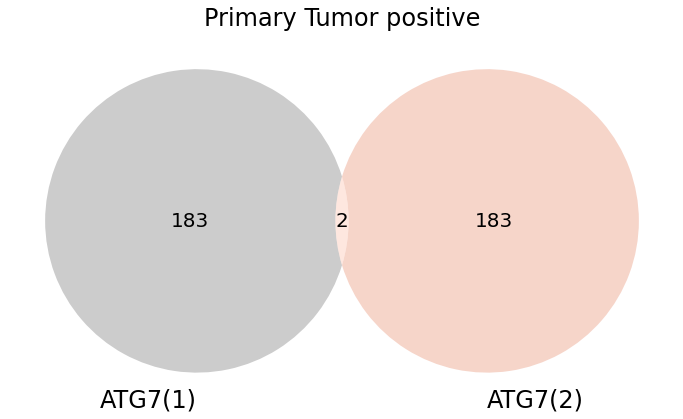

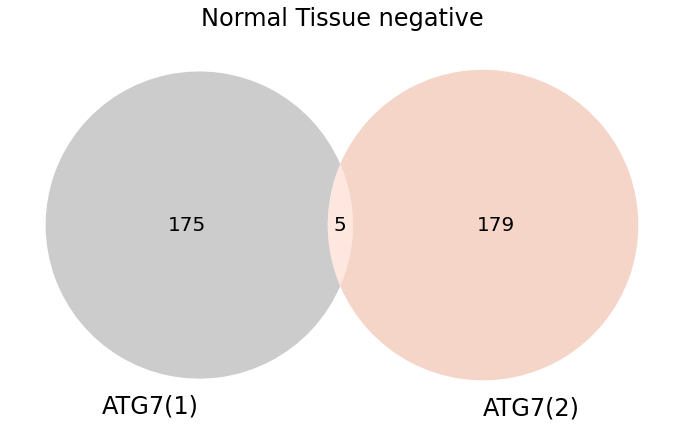

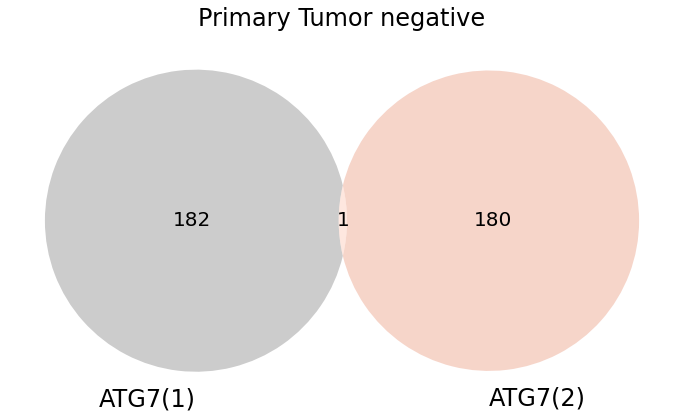

<Figure size 864x576 with 0 Axes>

In [62]:
#VENN DIAGRAMS FOR the 1% of the genes
data_pos =  [
         [all_corr_positiv_extremities[0], all_corr_positiv_extremities[1], 'Normal Tissue', 'positive'], 
         [all_corr_positiv_extremities[2], all_corr_positiv_extremities[3], 'Primary Tumor', 'positive']
         ]

data_neg =  [
         [all_corr_negativ_extremities[0], all_corr_negativ_extremities[1], 'Normal Tissue', 'negative'], 
         [all_corr_negativ_extremities[2], all_corr_negativ_extremities[3], 'Primary Tumor', 'negative']
         ]

data = data_pos + data_neg

for dfs in data:
    set1 = set(dfs[0]['hgnc_symbol'])
    set2 = set(dfs[1]['hgnc_symbol'])
    subset = (set1, set2)

    #save results in list
    with_only1 = list(set2.symmetric_difference(set1) & set1)
    with_only2 = list(set2.symmetric_difference(set1) & set2)
    intersection = set1.intersection(set2)

    #create a dictionnary
    d = dict(Only_ATG7_1 = with_only1, Only_ATG7_2 = with_only2, Intersection= intersection)

    #Convert to dataframe
    df_only_and_intersection = pandas.DataFrame.from_dict(d, orient='index')
    name_file = 'only_and_intersection_isos'+dfs[2]+dfs[3]
       
    #Transpose to have a better table and save
    df_only_and_intersection = df_only_and_intersection.transpose()
    df_only_and_intersection['info'] = dfs[2]+dfs[3]
    
    path = 'ATG7/table_correlation_enrichr/all_tissue_ATG7/'
    df_only_and_intersection.to_excel(output_file_directory+path+name_file+'.xlsx', index=False)
    
    #Venn Diagram
    venn2(subset, set_labels=('ATG7(1)', 'ATG7(2)'), set_colors=('grey', 'darksalmon'))
    label_title = dfs[2] + ' ' + dfs[3]
    plt.title(label_title)
    plt.show()
    plt.clf()
    print()

In [63]:
print(len(all_corr_negativ_extremities), 'iso1_norm, iso2_norm, iso1_prim, iso2_prim')

4 iso1_norm, iso2_norm, iso1_prim, iso2_prim


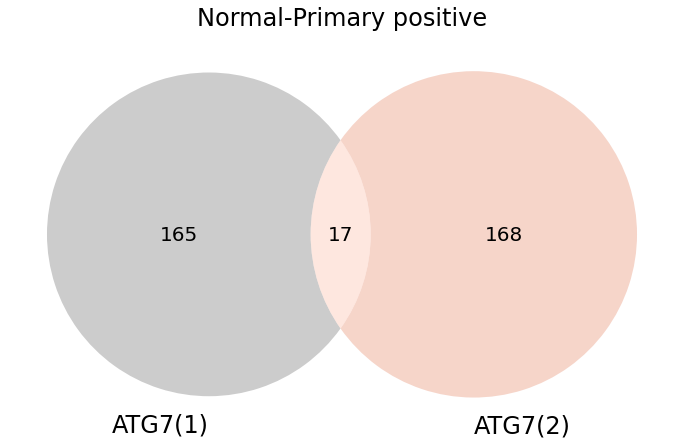

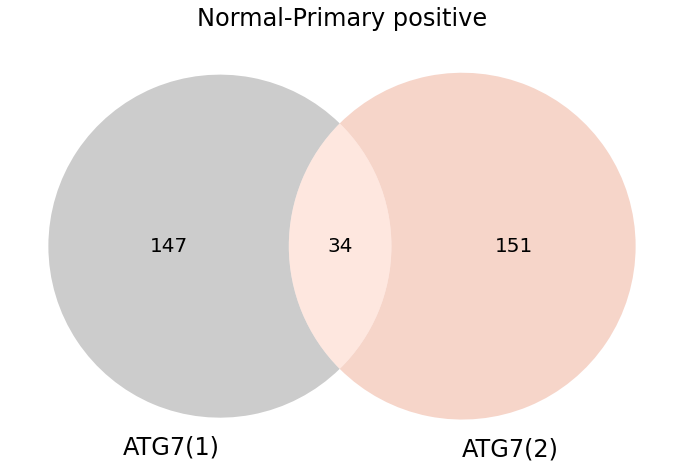

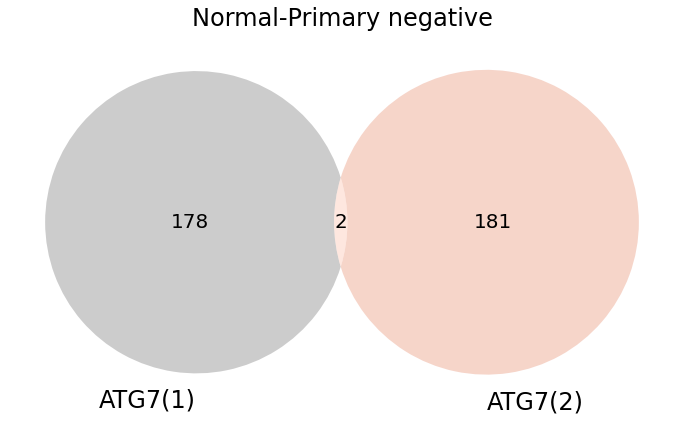

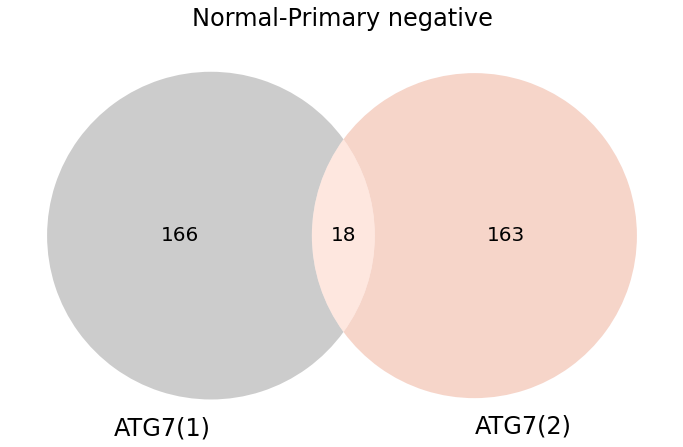

<Figure size 864x576 with 0 Axes>

In [64]:
#VENN DIAGRAMS FOR COMMUN NORM/PRIM for the 1% of correlated genes
data_pos =  [
         [all_corr_positiv_extremities[0], all_corr_positiv_extremities[2], 'Normal-Primary', 'positive'], 
         [all_corr_positiv_extremities[1], all_corr_positiv_extremities[3], 'Normal-Primary', 'positive']
         ]

data_neg =  [
         [all_corr_negativ_extremities[0], all_corr_negativ_extremities[2], 'Normal-Primary', 'negative'], 
         [all_corr_negativ_extremities[1], all_corr_negativ_extremities[3], 'Normal-Primary', 'negative']
         ]

data = data_pos + data_neg

for dfs in data:
    set1 = set(dfs[0]['hgnc_symbol'])
    set2 = set(dfs[1]['hgnc_symbol'])
    subset = (set1, set2)

    #save results in list
    with_only1 = list(set2.symmetric_difference(set1) & set1)
    with_only2 = list(set2.symmetric_difference(set1) & set2)
    intersection = set1.intersection(set2)

    #create a dictionnary
    d = dict(Only_ATG7_1 = with_only1, Only_ATG7_2 = with_only2, Intersection= intersection)

    #Convert to dataframe
    df_only_and_intersection = pandas.DataFrame.from_dict(d, orient='index')
    name_file = 'only_and_intersection_isos'+dfs[2]+dfs[3]
       
    #Transpose to have a better table and save
    df_only_and_intersection = df_only_and_intersection.transpose()
    df_only_and_intersection['info'] = dfs[2]+dfs[3]
    
    path = 'ATG7/table_correlation_enrichr/all_tissue_ATG7/'
    df_only_and_intersection.savefig(output_file_directory+path+name_file+'.xlsx')
    
    #Venn Diagram
    venn2(subset, set_labels=('ATG7(1)', 'ATG7(2)'), set_colors=('grey', 'darksalmon'))
    label_title = dfs[2] + ' ' + dfs[3]
    plt.title(label_title)
    plt.show()
    plt.clf()
    print()

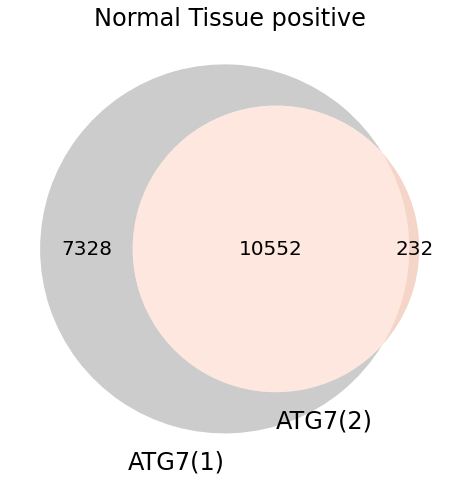

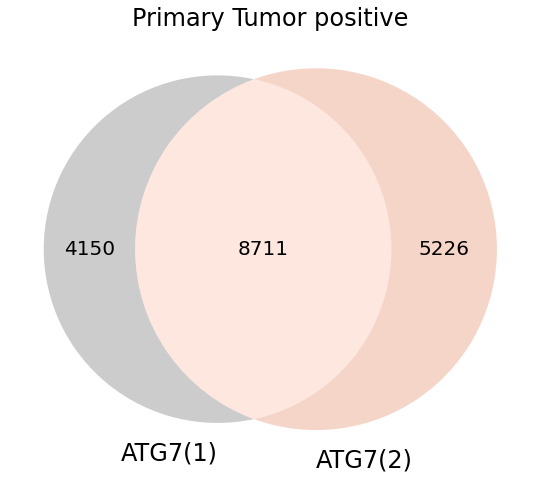

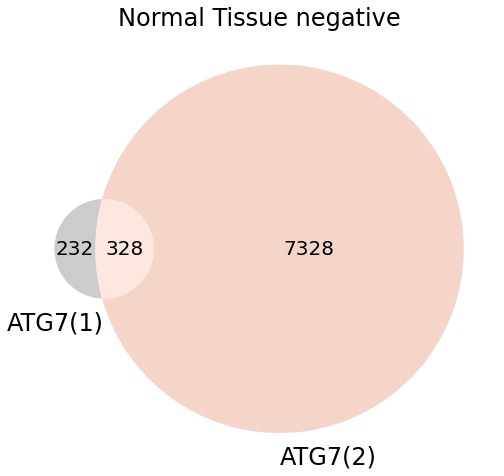

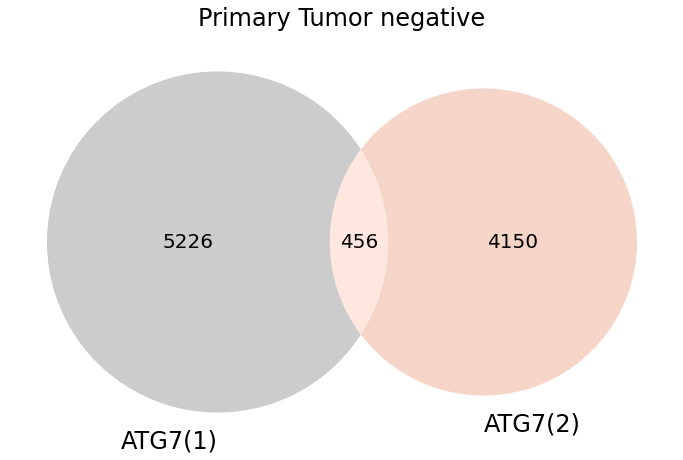

<Figure size 864x576 with 0 Axes>

In [65]:
#VENN DIAGRAMS FOR 100% of the genes

data_pos =  [
         [all_positiv_corr_spearman[0], all_positiv_corr_spearman[1], 'Normal Tissue', 'positive'], 
         [all_positiv_corr_spearman[2], all_positiv_corr_spearman[3], 'Primary Tumor', 'positive']
         ]

data_neg =  [
         [all_negativ_corr_spearman[0], all_negativ_corr_spearman[1], 'Normal Tissue', 'negative'], 
         [all_negativ_corr_spearman[2], all_negativ_corr_spearman[3], 'Primary Tumor', 'negative']
         ]

data = data_pos + data_neg

list_only1 = []
list_only2 = []

for dfs in data:
  set1 = set(dfs[0]['ensembl_gene_id'])
  set2 = set(dfs[1]['ensembl_gene_id'])
  subset = (set1, set2)

  #just to save some results in list
  with_only1 = set2.symmetric_difference(set1) & set1
  list_only1.append(with_only1)

  with_only2 = set2.symmetric_difference(set1) & set2
  list_only2.append(with_only2)

  #Venn Diagram
  venn2(subset, set_labels=('ATG7(1)', 'ATG7(2)'), set_colors=('grey', 'darksalmon'))
  label_title = dfs[2] + ' ' + dfs[3]
  plt.title(label_title)
  plt.show()
  plt.clf()
  print()



In [66]:
print((len(list_only2)), '= norm_pos_iso2, norm_neg_iso2, prim_pos_iso2, prim_neg_iso2, ')

4 = norm_pos_iso2, norm_neg_iso2, prim_pos_iso2, prim_neg_iso2, 


# VII] HK2

In [67]:
#because ATG7(2) expression is correlated with HK2 in Normal Tissue 
#and we know HK2 is not expressed in all tissue. Where HK2 is expressed ?

      Primary_Site  ATG7(total)   ATG7(1)   ATG7(2)        HK2
26          Testis    22.559422  9.606273  3.520579  35.903950
15          Muscle     6.394430  2.361606  1.179131  21.102146
0   Adipose Tissue    13.205544  6.711094  1.538953  20.953111
3            Blood    13.524349  2.856719  3.904353  19.003701
8            Colon     9.507805  5.548414  0.830093  17.250307


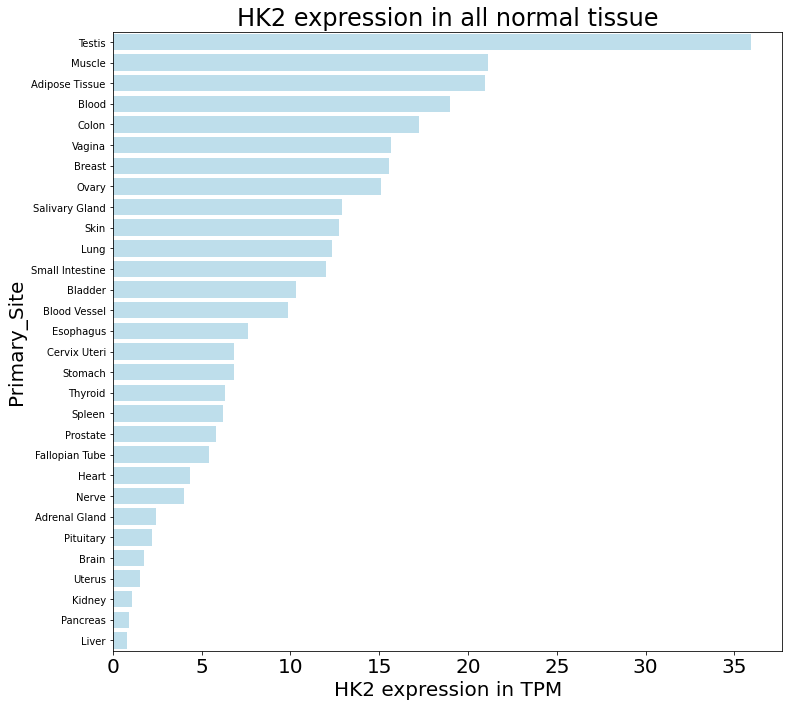

            Primary_Site  ATG7(total)   ATG7(1)   ATG7(2)        HK2
10  Head And Neck Region    14.523102  5.530002  3.438664  42.414856
8              Esophagus    14.947511  5.657722  3.145191  39.530130
6                  Colon    14.273716  5.547910  3.038977  35.624687
20                Rectum    14.132734  5.812341  2.999638  33.519051
14                  Lung    15.212185  5.684523  3.269985  32.241548


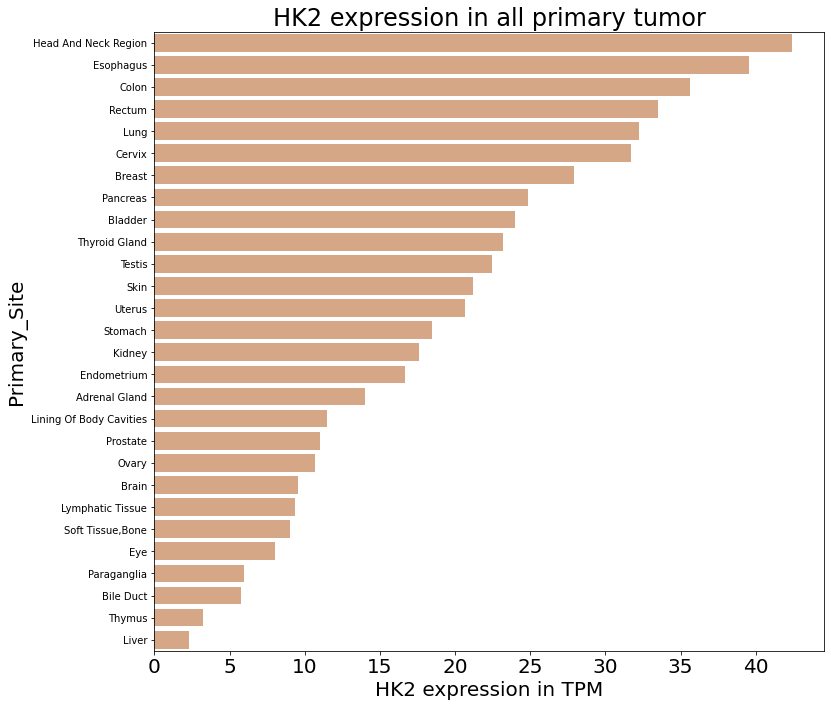

<Figure size 864x576 with 0 Axes>

In [68]:
dfs = [[ensembl_normal_atg7_proteinGE, 'normal tissue', 'skyblue'], 
       [ensembl_primary_atg7_proteinGE, 'primary tumor', 'chocolate']]
for df in dfs:
    HK2_express = df[0][['Primary_Site', 'ATG7', 'ATG7_1', 'ATG7_2', 'ENSG00000159399']]
    HK2_express = HK2_express.dropna(axis=0)
    HK2_express["ATG7(total)"] = pow(2,HK2_express['ATG7'])-0.001
    HK2_express["ATG7(1)"] = pow(2,HK2_express['ATG7_1'])-0.001
    HK2_express["ATG7(2)"] = pow(2,HK2_express['ATG7_2'])-0.001
    HK2_express["HK2"] = pow(2,HK2_express['ENSG00000159399'])-0.001

    HK2_express= HK2_express[['Primary_Site', 'ATG7(total)', 'ATG7(1)', 'ATG7(2)', 'HK2']]
    HK2_express['ATG7(2)'] = HK2_express['ATG7(2)'].abs()
    HK2_express= HK2_express.groupby('Primary_Site').agg(numpy.mean)
    HK2_express = HK2_express.reset_index()
    HK2_express = HK2_express.sort_values(['HK2'], ascending = False)
    print(HK2_express.head())
    
    # Seaborn
    seaborn.barplot(data = HK2_express, x =  'HK2', y = 'Primary_Site', color = df[2], alpha=0.6)
    # seaborn.barplot(data = HK2_express, x =  'ATG7(total)', y = 'Primary_Site', color = 'orange', alpha=0.6)
    plt.title('HK2 expression in all ' + df[1])
    plt.xlabel('HK2 expression in TPM')
    plt.subplots_adjust(top=1.2)
    plt.show()
    plt.clf()